In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "uni95"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 396
Categorical features: 10
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 468
Categorical Columns: 10


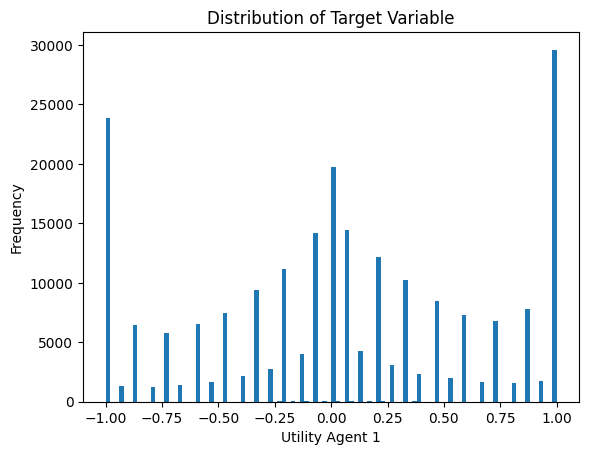

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.497643


[200]	valid_0's rmse: 0.481142


[300]	valid_0's rmse: 0.471153


[400]	valid_0's rmse: 0.464563


[500]	valid_0's rmse: 0.459705


[600]	valid_0's rmse: 0.456423


[700]	valid_0's rmse: 0.453449


[800]	valid_0's rmse: 0.45102


[900]	valid_0's rmse: 0.448514


[1000]	valid_0's rmse: 0.446508


[1100]	valid_0's rmse: 0.444742


[1200]	valid_0's rmse: 0.443205


[1300]	valid_0's rmse: 0.442279


[1400]	valid_0's rmse: 0.441133


[1500]	valid_0's rmse: 0.440224


[1600]	valid_0's rmse: 0.439288


[1700]	valid_0's rmse: 0.438499


[1800]	valid_0's rmse: 0.43785


[1900]	valid_0's rmse: 0.437359


[2000]	valid_0's rmse: 0.43685


[2100]	valid_0's rmse: 0.436288


[2200]	valid_0's rmse: 0.435904


[2300]	valid_0's rmse: 0.43554


[2400]	valid_0's rmse: 0.435155


[2500]	valid_0's rmse: 0.434872


[2600]	valid_0's rmse: 0.434505


[2700]	valid_0's rmse: 0.43422


[2800]	valid_0's rmse: 0.43389


[2900]	valid_0's rmse: 0.433668


[3000]	valid_0's rmse: 0.433417


[3100]	valid_0's rmse: 0.43322


[3200]	valid_0's rmse: 0.433023


[3300]	valid_0's rmse: 0.432728


[3400]	valid_0's rmse: 0.432591


[3500]	valid_0's rmse: 0.432422


[3600]	valid_0's rmse: 0.432314


[3700]	valid_0's rmse: 0.432285


[3800]	valid_0's rmse: 0.432209


[3900]	valid_0's rmse: 0.432051


[4000]	valid_0's rmse: 0.43189


[4100]	valid_0's rmse: 0.43181


[4200]	valid_0's rmse: 0.431604


[4300]	valid_0's rmse: 0.431543


[4400]	valid_0's rmse: 0.431399


[4500]	valid_0's rmse: 0.431292


[4600]	valid_0's rmse: 0.43114


[4700]	valid_0's rmse: 0.431007


[4800]	valid_0's rmse: 0.430935


[4900]	valid_0's rmse: 0.430899


[5000]	valid_0's rmse: 0.430828


[5100]	valid_0's rmse: 0.430797


[5200]	valid_0's rmse: 0.430764


[5300]	valid_0's rmse: 0.430711


[5400]	valid_0's rmse: 0.430627


[5500]	valid_0's rmse: 0.430554


[5600]	valid_0's rmse: 0.430525


[5700]	valid_0's rmse: 0.430466


[5800]	valid_0's rmse: 0.430371


[5900]	valid_0's rmse: 0.430343


[6000]	valid_0's rmse: 0.430234


[6100]	valid_0's rmse: 0.430224


[6200]	valid_0's rmse: 0.430219


[6300]	valid_0's rmse: 0.43015


[6400]	valid_0's rmse: 0.430148


[6500]	valid_0's rmse: 0.430178


[6600]	valid_0's rmse: 0.430091


[6700]	valid_0's rmse: 0.43007


[6800]	valid_0's rmse: 0.430033


[6900]	valid_0's rmse: 0.430044


[7000]	valid_0's rmse: 0.429994


[7100]	valid_0's rmse: 0.429961


[7200]	valid_0's rmse: 0.429926


[7300]	valid_0's rmse: 0.429899


[7400]	valid_0's rmse: 0.429828


[7500]	valid_0's rmse: 0.429821


[7600]	valid_0's rmse: 0.429818


[7700]	valid_0's rmse: 0.429754


[7800]	valid_0's rmse: 0.429739


[7900]	valid_0's rmse: 0.429731


[8000]	valid_0's rmse: 0.429718


[8100]	valid_0's rmse: 0.429665


[8200]	valid_0's rmse: 0.429673


[8300]	valid_0's rmse: 0.429666


[8400]	valid_0's rmse: 0.429669


[8500]	valid_0's rmse: 0.429708


[8600]	valid_0's rmse: 0.429697


[8700]	valid_0's rmse: 0.429715


[8800]	valid_0's rmse: 0.429713


[8900]	valid_0's rmse: 0.429728


[9000]	valid_0's rmse: 0.429669


[9100]	valid_0's rmse: 0.429648


[9200]	valid_0's rmse: 0.429657


[9300]	valid_0's rmse: 0.429583


[9400]	valid_0's rmse: 0.429656


[9500]	valid_0's rmse: 0.42958


[9600]	valid_0's rmse: 0.429613


[9700]	valid_0's rmse: 0.429632


[9800]	valid_0's rmse: 0.429616


[9900]	valid_0's rmse: 0.429629


[10000]	valid_0's rmse: 0.429657


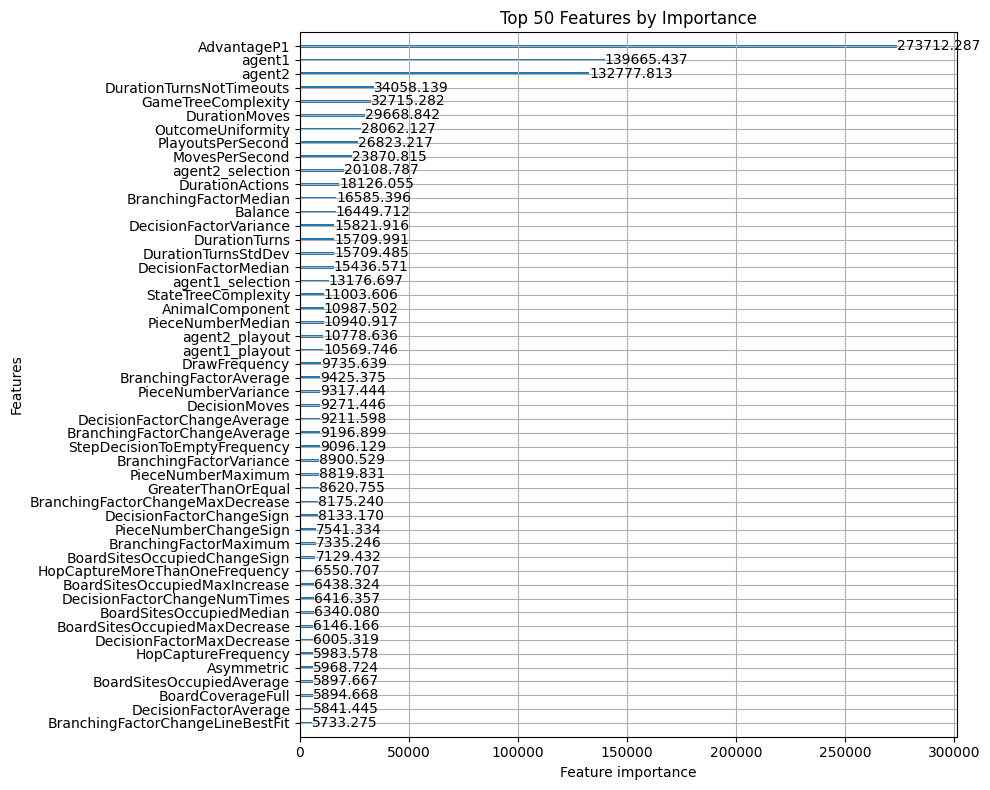

Fold 1 - RMSE: 0.42915237458957184
Fold 2


[100]	valid_0's rmse: 0.510321


[200]	valid_0's rmse: 0.491901


[300]	valid_0's rmse: 0.484788


[400]	valid_0's rmse: 0.479429


[500]	valid_0's rmse: 0.475284


[600]	valid_0's rmse: 0.472562


[700]	valid_0's rmse: 0.470456


[800]	valid_0's rmse: 0.468278


[900]	valid_0's rmse: 0.466379


[1000]	valid_0's rmse: 0.465142


[1100]	valid_0's rmse: 0.463771


[1200]	valid_0's rmse: 0.462821


[1300]	valid_0's rmse: 0.462029


[1400]	valid_0's rmse: 0.461036


[1500]	valid_0's rmse: 0.460393


[1600]	valid_0's rmse: 0.45972


[1700]	valid_0's rmse: 0.459039


[1800]	valid_0's rmse: 0.458476


[1900]	valid_0's rmse: 0.458049


[2000]	valid_0's rmse: 0.457689


[2100]	valid_0's rmse: 0.457207


[2200]	valid_0's rmse: 0.456561


[2300]	valid_0's rmse: 0.456308


[2400]	valid_0's rmse: 0.456228


[2500]	valid_0's rmse: 0.455727


[2600]	valid_0's rmse: 0.455487


[2700]	valid_0's rmse: 0.45516


[2800]	valid_0's rmse: 0.454925


[2900]	valid_0's rmse: 0.454662


[3000]	valid_0's rmse: 0.454526


[3100]	valid_0's rmse: 0.454079


[3200]	valid_0's rmse: 0.453894


[3300]	valid_0's rmse: 0.453641


[3400]	valid_0's rmse: 0.453441


[3500]	valid_0's rmse: 0.453231


[3600]	valid_0's rmse: 0.45312


[3700]	valid_0's rmse: 0.452996


[3800]	valid_0's rmse: 0.4527


[3900]	valid_0's rmse: 0.452599


[4000]	valid_0's rmse: 0.452402


[4100]	valid_0's rmse: 0.452306


[4200]	valid_0's rmse: 0.452208


[4300]	valid_0's rmse: 0.452153


[4400]	valid_0's rmse: 0.451971


[4500]	valid_0's rmse: 0.451955


[4600]	valid_0's rmse: 0.451918


[4700]	valid_0's rmse: 0.451889


[4800]	valid_0's rmse: 0.451774


[4900]	valid_0's rmse: 0.451609


[5000]	valid_0's rmse: 0.451543


[5100]	valid_0's rmse: 0.451454


[5200]	valid_0's rmse: 0.451446


[5300]	valid_0's rmse: 0.451401


[5400]	valid_0's rmse: 0.451309


[5500]	valid_0's rmse: 0.451312


[5600]	valid_0's rmse: 0.451209


[5700]	valid_0's rmse: 0.451143


[5800]	valid_0's rmse: 0.45107


[5900]	valid_0's rmse: 0.451052


[6000]	valid_0's rmse: 0.45098


[6100]	valid_0's rmse: 0.45095


[6200]	valid_0's rmse: 0.450865


[6300]	valid_0's rmse: 0.450815


[6400]	valid_0's rmse: 0.450792


[6500]	valid_0's rmse: 0.450721


[6600]	valid_0's rmse: 0.450658


[6700]	valid_0's rmse: 0.450544


[6800]	valid_0's rmse: 0.450493


[6900]	valid_0's rmse: 0.450479


[7000]	valid_0's rmse: 0.450383


[7100]	valid_0's rmse: 0.450347


[7200]	valid_0's rmse: 0.45028


[7300]	valid_0's rmse: 0.45023


[7400]	valid_0's rmse: 0.450119


[7500]	valid_0's rmse: 0.450058


[7600]	valid_0's rmse: 0.44998


[7700]	valid_0's rmse: 0.449916


[7800]	valid_0's rmse: 0.449902


[7900]	valid_0's rmse: 0.449876


[8000]	valid_0's rmse: 0.449884


[8100]	valid_0's rmse: 0.449874


[8200]	valid_0's rmse: 0.449822


[8300]	valid_0's rmse: 0.449872


[8400]	valid_0's rmse: 0.449756


[8500]	valid_0's rmse: 0.449795


[8600]	valid_0's rmse: 0.449756


[8700]	valid_0's rmse: 0.449753


[8800]	valid_0's rmse: 0.449726


[8900]	valid_0's rmse: 0.449721


[9000]	valid_0's rmse: 0.449705


[9100]	valid_0's rmse: 0.449707


[9200]	valid_0's rmse: 0.449736


[9300]	valid_0's rmse: 0.449721


[9400]	valid_0's rmse: 0.449736


[9500]	valid_0's rmse: 0.44978


[9600]	valid_0's rmse: 0.449755


[9700]	valid_0's rmse: 0.449695


[9800]	valid_0's rmse: 0.44973


[9900]	valid_0's rmse: 0.449748


[10000]	valid_0's rmse: 0.449736


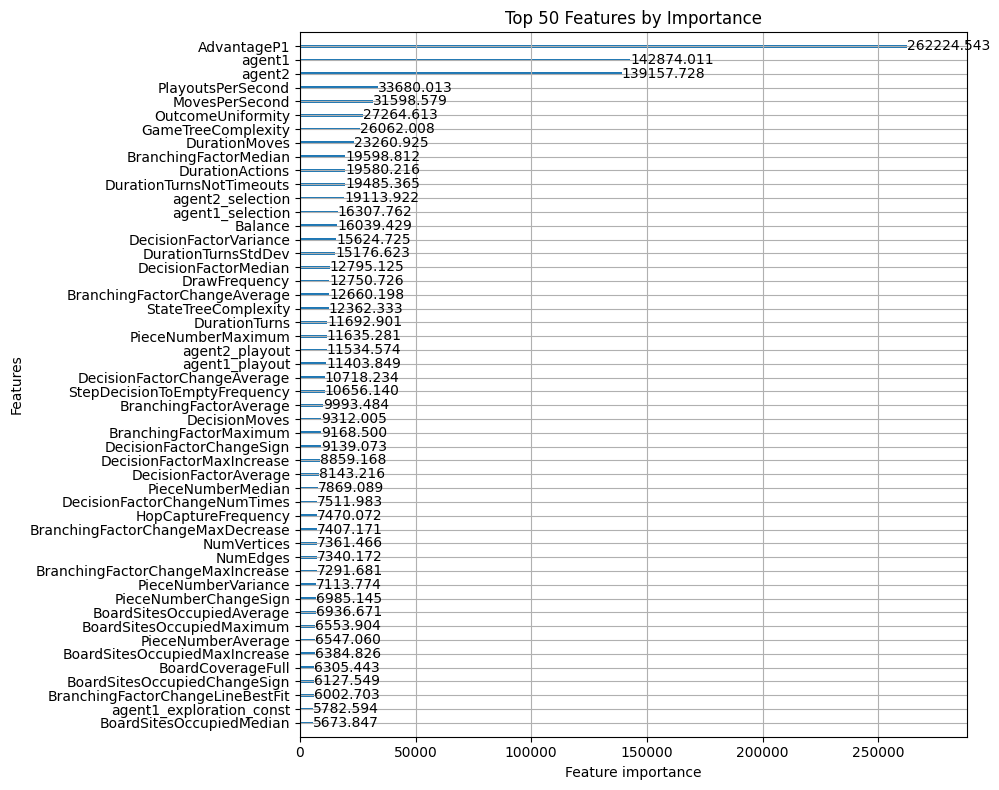

Fold 2 - RMSE: 0.4490975712780015
Fold 3


[100]	valid_0's rmse: 0.517025


[200]	valid_0's rmse: 0.489064


[300]	valid_0's rmse: 0.477565


[400]	valid_0's rmse: 0.471945


[500]	valid_0's rmse: 0.468308


[600]	valid_0's rmse: 0.465508


[700]	valid_0's rmse: 0.46277


[800]	valid_0's rmse: 0.460827


[900]	valid_0's rmse: 0.4587


[1000]	valid_0's rmse: 0.456967


[1100]	valid_0's rmse: 0.455578


[1200]	valid_0's rmse: 0.454198


[1300]	valid_0's rmse: 0.452963


[1400]	valid_0's rmse: 0.452221


[1500]	valid_0's rmse: 0.451325


[1600]	valid_0's rmse: 0.450605


[1700]	valid_0's rmse: 0.450211


[1800]	valid_0's rmse: 0.449768


[1900]	valid_0's rmse: 0.449365


[2000]	valid_0's rmse: 0.448841


[2100]	valid_0's rmse: 0.448394


[2200]	valid_0's rmse: 0.447914


[2300]	valid_0's rmse: 0.447625


[2400]	valid_0's rmse: 0.44719


[2500]	valid_0's rmse: 0.447022


[2600]	valid_0's rmse: 0.446638


[2700]	valid_0's rmse: 0.446395


[2800]	valid_0's rmse: 0.44603


[2900]	valid_0's rmse: 0.445752


[3000]	valid_0's rmse: 0.4455


[3100]	valid_0's rmse: 0.445284


[3200]	valid_0's rmse: 0.445109


[3300]	valid_0's rmse: 0.444822


[3400]	valid_0's rmse: 0.444644


[3500]	valid_0's rmse: 0.444551


[3600]	valid_0's rmse: 0.444404


[3700]	valid_0's rmse: 0.4442


[3800]	valid_0's rmse: 0.444093


[3900]	valid_0's rmse: 0.44402


[4000]	valid_0's rmse: 0.443872


[4100]	valid_0's rmse: 0.44372


[4200]	valid_0's rmse: 0.443572


[4300]	valid_0's rmse: 0.443469


[4400]	valid_0's rmse: 0.443339


[4500]	valid_0's rmse: 0.443359


[4600]	valid_0's rmse: 0.443302


[4700]	valid_0's rmse: 0.443198


[4800]	valid_0's rmse: 0.44305


[4900]	valid_0's rmse: 0.442971


[5000]	valid_0's rmse: 0.442886


[5100]	valid_0's rmse: 0.442821


[5200]	valid_0's rmse: 0.442725


[5300]	valid_0's rmse: 0.442598


[5400]	valid_0's rmse: 0.442595


[5500]	valid_0's rmse: 0.442592


[5600]	valid_0's rmse: 0.442506


[5700]	valid_0's rmse: 0.442436


[5800]	valid_0's rmse: 0.44242


[5900]	valid_0's rmse: 0.442396


[6000]	valid_0's rmse: 0.442363


[6100]	valid_0's rmse: 0.442343


[6200]	valid_0's rmse: 0.442285


[6300]	valid_0's rmse: 0.442159


[6400]	valid_0's rmse: 0.442093


[6500]	valid_0's rmse: 0.441973


[6600]	valid_0's rmse: 0.441924


[6700]	valid_0's rmse: 0.441849


[6800]	valid_0's rmse: 0.441855


[6900]	valid_0's rmse: 0.441852


[7000]	valid_0's rmse: 0.441862


[7100]	valid_0's rmse: 0.441854


[7200]	valid_0's rmse: 0.441843


[7300]	valid_0's rmse: 0.441813


[7400]	valid_0's rmse: 0.441771


[7500]	valid_0's rmse: 0.441673


[7600]	valid_0's rmse: 0.441625


[7700]	valid_0's rmse: 0.441563


[7800]	valid_0's rmse: 0.441456


[7900]	valid_0's rmse: 0.441385


[8000]	valid_0's rmse: 0.441322


[8100]	valid_0's rmse: 0.44138


[8200]	valid_0's rmse: 0.441352


[8300]	valid_0's rmse: 0.441299


[8400]	valid_0's rmse: 0.441236


[8500]	valid_0's rmse: 0.441276


[8600]	valid_0's rmse: 0.441217


[8700]	valid_0's rmse: 0.441195


[8800]	valid_0's rmse: 0.441203


[8900]	valid_0's rmse: 0.441139


[9000]	valid_0's rmse: 0.441127


[9100]	valid_0's rmse: 0.441078


[9200]	valid_0's rmse: 0.441026


[9300]	valid_0's rmse: 0.441029


[9400]	valid_0's rmse: 0.441009


[9500]	valid_0's rmse: 0.440977


[9600]	valid_0's rmse: 0.440917


[9700]	valid_0's rmse: 0.440892


[9800]	valid_0's rmse: 0.440884


[9900]	valid_0's rmse: 0.440861


[10000]	valid_0's rmse: 0.440835


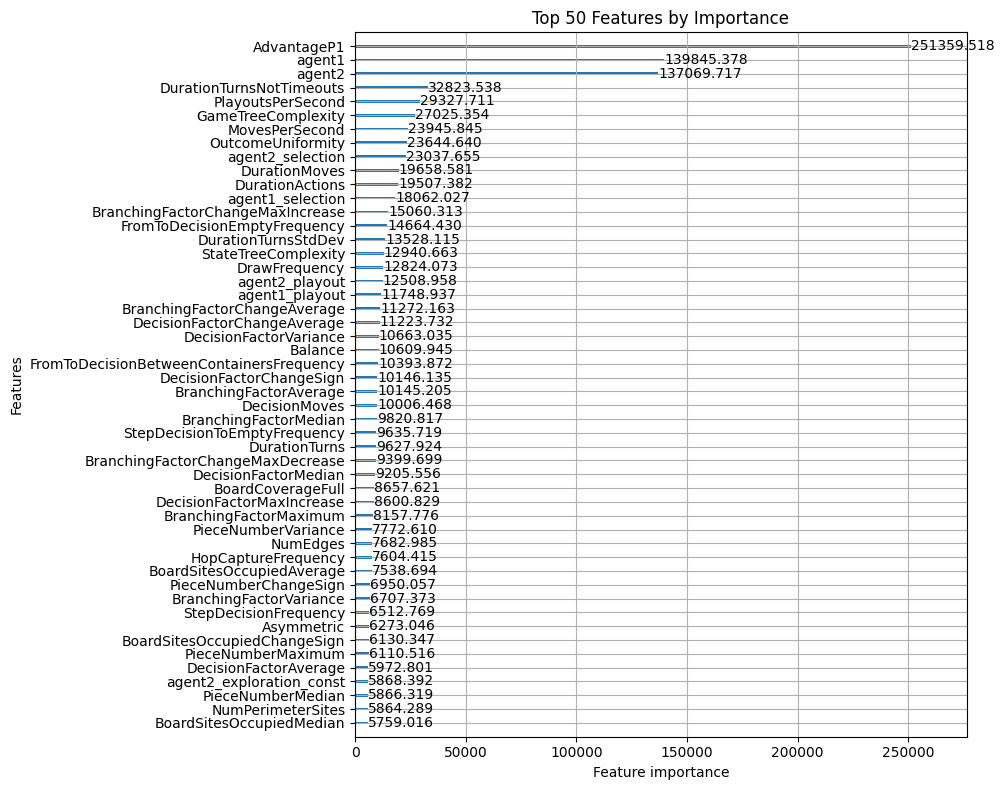

Fold 3 - RMSE: 0.4402154541222121
Fold 4


[100]	valid_0's rmse: 0.519908


[200]	valid_0's rmse: 0.494609


[300]	valid_0's rmse: 0.483891


[400]	valid_0's rmse: 0.475849


[500]	valid_0's rmse: 0.470229


[600]	valid_0's rmse: 0.465256


[700]	valid_0's rmse: 0.462194


[800]	valid_0's rmse: 0.459078


[900]	valid_0's rmse: 0.456672


[1000]	valid_0's rmse: 0.454734


[1100]	valid_0's rmse: 0.453325


[1200]	valid_0's rmse: 0.452183


[1300]	valid_0's rmse: 0.451087


[1400]	valid_0's rmse: 0.450198


[1500]	valid_0's rmse: 0.449186


[1600]	valid_0's rmse: 0.4485


[1700]	valid_0's rmse: 0.447728


[1800]	valid_0's rmse: 0.447067


[1900]	valid_0's rmse: 0.446404


[2000]	valid_0's rmse: 0.445853


[2100]	valid_0's rmse: 0.445497


[2200]	valid_0's rmse: 0.44502


[2300]	valid_0's rmse: 0.444448


[2400]	valid_0's rmse: 0.44415


[2500]	valid_0's rmse: 0.443837


[2600]	valid_0's rmse: 0.443451


[2700]	valid_0's rmse: 0.443131


[2800]	valid_0's rmse: 0.442788


[2900]	valid_0's rmse: 0.442402


[3000]	valid_0's rmse: 0.44206


[3100]	valid_0's rmse: 0.441681


[3200]	valid_0's rmse: 0.441497


[3300]	valid_0's rmse: 0.44128


[3400]	valid_0's rmse: 0.441177


[3500]	valid_0's rmse: 0.441064


[3600]	valid_0's rmse: 0.440967


[3700]	valid_0's rmse: 0.440887


[3800]	valid_0's rmse: 0.440746


[3900]	valid_0's rmse: 0.440581


[4000]	valid_0's rmse: 0.440388


[4100]	valid_0's rmse: 0.440242


[4200]	valid_0's rmse: 0.440058


[4300]	valid_0's rmse: 0.439915


[4400]	valid_0's rmse: 0.439806


[4500]	valid_0's rmse: 0.43961


[4600]	valid_0's rmse: 0.439511


[4700]	valid_0's rmse: 0.439401


[4800]	valid_0's rmse: 0.439265


[4900]	valid_0's rmse: 0.439167


[5000]	valid_0's rmse: 0.439009


[5100]	valid_0's rmse: 0.438917


[5200]	valid_0's rmse: 0.438845


[5300]	valid_0's rmse: 0.438848


[5400]	valid_0's rmse: 0.438755


[5500]	valid_0's rmse: 0.438712


[5600]	valid_0's rmse: 0.438606


[5700]	valid_0's rmse: 0.438547


[5800]	valid_0's rmse: 0.438454


[5900]	valid_0's rmse: 0.438384


[6000]	valid_0's rmse: 0.438286


[6100]	valid_0's rmse: 0.438162


[6200]	valid_0's rmse: 0.43809


[6300]	valid_0's rmse: 0.438029


[6400]	valid_0's rmse: 0.437973


[6500]	valid_0's rmse: 0.43784


[6600]	valid_0's rmse: 0.437814


[6700]	valid_0's rmse: 0.437689


[6800]	valid_0's rmse: 0.43762


[6900]	valid_0's rmse: 0.437485


[7000]	valid_0's rmse: 0.437386


[7100]	valid_0's rmse: 0.43737


[7200]	valid_0's rmse: 0.437309


[7300]	valid_0's rmse: 0.437252


[7400]	valid_0's rmse: 0.437223


[7500]	valid_0's rmse: 0.437201


[7600]	valid_0's rmse: 0.437203


[7700]	valid_0's rmse: 0.437151


[7800]	valid_0's rmse: 0.437159


[7900]	valid_0's rmse: 0.437148


[8000]	valid_0's rmse: 0.437099


[8100]	valid_0's rmse: 0.437033


[8200]	valid_0's rmse: 0.436996


[8300]	valid_0's rmse: 0.436989


[8400]	valid_0's rmse: 0.436949


[8500]	valid_0's rmse: 0.436984


[8600]	valid_0's rmse: 0.436908


[8700]	valid_0's rmse: 0.436875


[8800]	valid_0's rmse: 0.436842


[8900]	valid_0's rmse: 0.436788


[9000]	valid_0's rmse: 0.436739


[9100]	valid_0's rmse: 0.436751


[9200]	valid_0's rmse: 0.436602


[9300]	valid_0's rmse: 0.436554


[9400]	valid_0's rmse: 0.436509


[9500]	valid_0's rmse: 0.436514


[9600]	valid_0's rmse: 0.436434


[9700]	valid_0's rmse: 0.436391


[9800]	valid_0's rmse: 0.436326


[9900]	valid_0's rmse: 0.436254


[10000]	valid_0's rmse: 0.43627


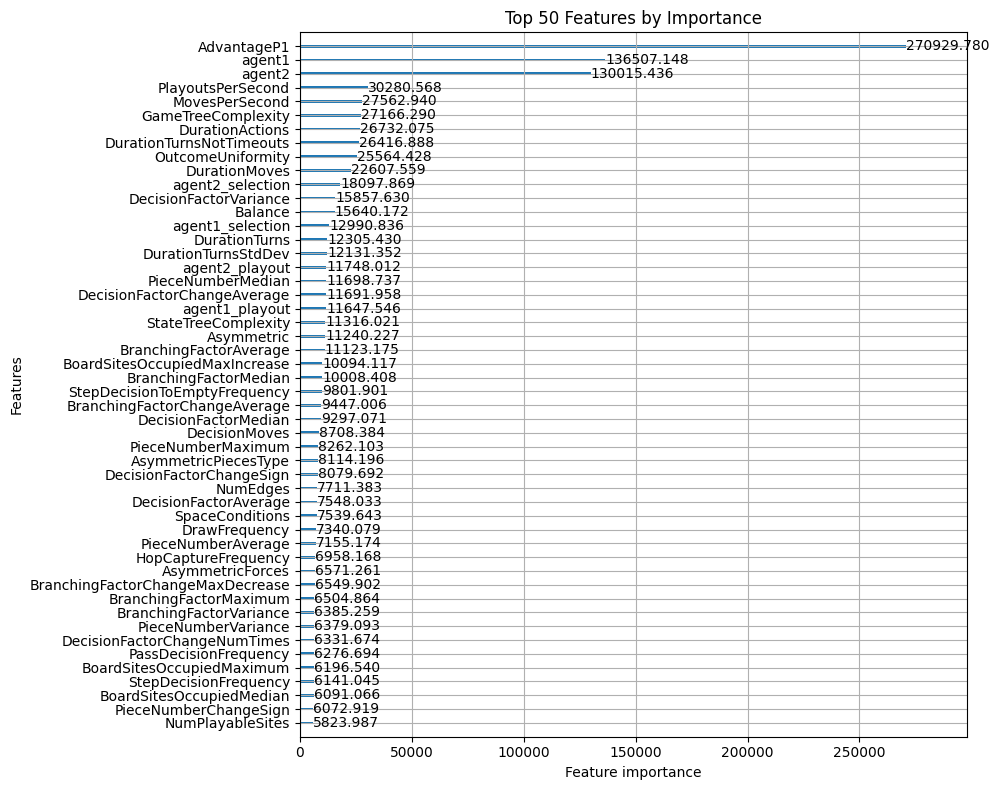

Fold 4 - RMSE: 0.4352119695115474
Fold 5


[100]	valid_0's rmse: 0.490032


[200]	valid_0's rmse: 0.470078


[300]	valid_0's rmse: 0.457273


[400]	valid_0's rmse: 0.448358


[500]	valid_0's rmse: 0.44122


[600]	valid_0's rmse: 0.436652


[700]	valid_0's rmse: 0.433753


[800]	valid_0's rmse: 0.430791


[900]	valid_0's rmse: 0.428299


[1000]	valid_0's rmse: 0.42665


[1100]	valid_0's rmse: 0.424771


[1200]	valid_0's rmse: 0.423283


[1300]	valid_0's rmse: 0.422007


[1400]	valid_0's rmse: 0.420543


[1500]	valid_0's rmse: 0.419663


[1600]	valid_0's rmse: 0.418802


[1700]	valid_0's rmse: 0.417822


[1800]	valid_0's rmse: 0.416893


[1900]	valid_0's rmse: 0.416256


[2000]	valid_0's rmse: 0.415604


[2100]	valid_0's rmse: 0.415134


[2200]	valid_0's rmse: 0.414454


[2300]	valid_0's rmse: 0.413977


[2400]	valid_0's rmse: 0.413589


[2500]	valid_0's rmse: 0.413117


[2600]	valid_0's rmse: 0.412646


[2700]	valid_0's rmse: 0.412316


[2800]	valid_0's rmse: 0.411956


[2900]	valid_0's rmse: 0.411598


[3000]	valid_0's rmse: 0.41122


[3100]	valid_0's rmse: 0.411085


[3200]	valid_0's rmse: 0.410907


[3300]	valid_0's rmse: 0.410656


[3400]	valid_0's rmse: 0.410439


[3500]	valid_0's rmse: 0.410148


[3600]	valid_0's rmse: 0.409935


[3700]	valid_0's rmse: 0.409783


[3800]	valid_0's rmse: 0.409632


[3900]	valid_0's rmse: 0.409351


[4000]	valid_0's rmse: 0.409241


[4100]	valid_0's rmse: 0.409069


[4200]	valid_0's rmse: 0.408923


[4300]	valid_0's rmse: 0.408692


[4400]	valid_0's rmse: 0.408621


[4500]	valid_0's rmse: 0.408461


[4600]	valid_0's rmse: 0.408314


[4700]	valid_0's rmse: 0.408175


[4800]	valid_0's rmse: 0.408023


[4900]	valid_0's rmse: 0.407903


[5000]	valid_0's rmse: 0.407762


[5100]	valid_0's rmse: 0.407736


[5200]	valid_0's rmse: 0.407631


[5300]	valid_0's rmse: 0.407611


[5400]	valid_0's rmse: 0.407539


[5500]	valid_0's rmse: 0.407438


[5600]	valid_0's rmse: 0.407373


[5700]	valid_0's rmse: 0.407242


[5800]	valid_0's rmse: 0.407144


[5900]	valid_0's rmse: 0.407096


[6000]	valid_0's rmse: 0.407021


[6100]	valid_0's rmse: 0.406964


[6200]	valid_0's rmse: 0.406867


[6300]	valid_0's rmse: 0.406891


[6400]	valid_0's rmse: 0.406844


[6500]	valid_0's rmse: 0.406805


[6600]	valid_0's rmse: 0.406761


[6700]	valid_0's rmse: 0.406758


[6800]	valid_0's rmse: 0.406691


[6900]	valid_0's rmse: 0.406559


[7000]	valid_0's rmse: 0.406505


[7100]	valid_0's rmse: 0.406506


[7200]	valid_0's rmse: 0.406441


[7300]	valid_0's rmse: 0.406467


[7400]	valid_0's rmse: 0.406441


[7500]	valid_0's rmse: 0.406409


[7600]	valid_0's rmse: 0.406389


[7700]	valid_0's rmse: 0.406393


[7800]	valid_0's rmse: 0.406321


[7900]	valid_0's rmse: 0.406321


[8000]	valid_0's rmse: 0.406294


[8100]	valid_0's rmse: 0.406244


[8200]	valid_0's rmse: 0.406209


[8300]	valid_0's rmse: 0.406245


[8400]	valid_0's rmse: 0.406217


[8500]	valid_0's rmse: 0.406198


[8600]	valid_0's rmse: 0.406131


[8700]	valid_0's rmse: 0.406179


[8800]	valid_0's rmse: 0.406144


[8900]	valid_0's rmse: 0.406117


[9000]	valid_0's rmse: 0.406071


[9100]	valid_0's rmse: 0.406058


[9200]	valid_0's rmse: 0.406072


[9300]	valid_0's rmse: 0.406021


[9400]	valid_0's rmse: 0.406017


[9500]	valid_0's rmse: 0.405993


[9600]	valid_0's rmse: 0.406039


[9700]	valid_0's rmse: 0.406066


[9800]	valid_0's rmse: 0.406046


[9900]	valid_0's rmse: 0.406054


[10000]	valid_0's rmse: 0.406048


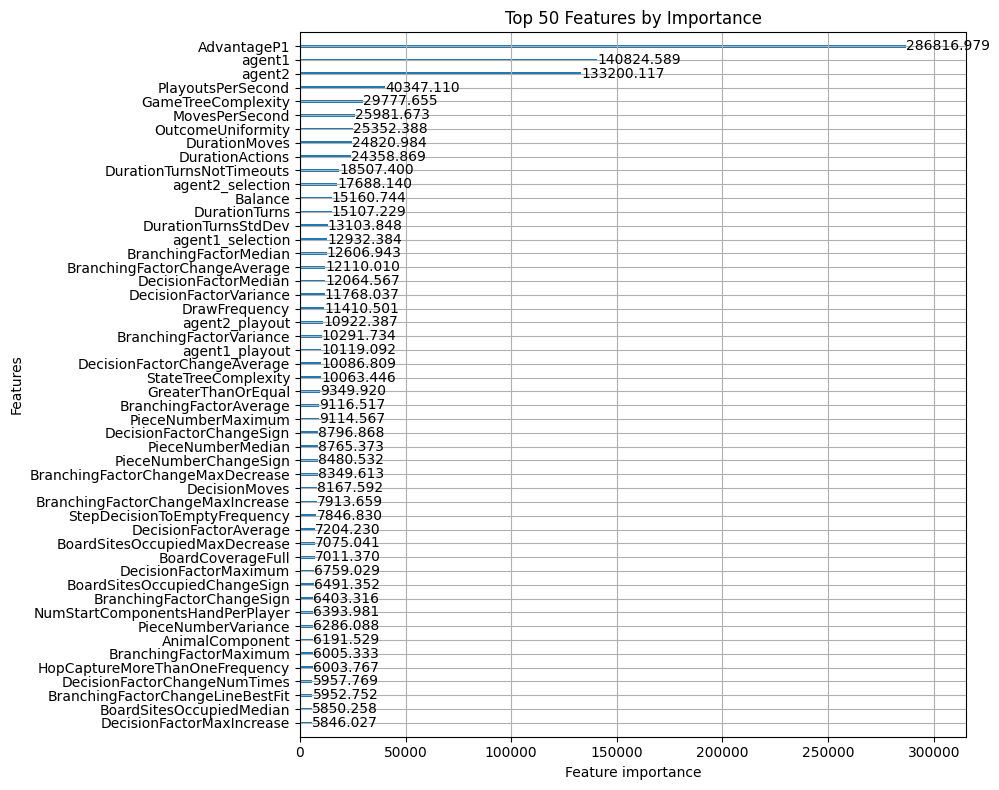

Fold 5 - RMSE: 0.4056651135909738
List of oof scores: [0.42915237458957184, 0.4490975712780015, 0.4402154541222121, 0.4352119695115474, 0.4056651135909738]
Average oof score: 0.43186849661846133


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.479836


[200]	valid_0's rmse: 0.460918


[300]	valid_0's rmse: 0.451738


[400]	valid_0's rmse: 0.445754


[500]	valid_0's rmse: 0.441157


[600]	valid_0's rmse: 0.438454


[700]	valid_0's rmse: 0.435955


[800]	valid_0's rmse: 0.433368


[900]	valid_0's rmse: 0.431748


[1000]	valid_0's rmse: 0.430143


[1100]	valid_0's rmse: 0.428749


[1200]	valid_0's rmse: 0.427939


[1300]	valid_0's rmse: 0.426929


[1400]	valid_0's rmse: 0.42619


[1500]	valid_0's rmse: 0.425489


[1600]	valid_0's rmse: 0.424762


[1700]	valid_0's rmse: 0.424232


[1800]	valid_0's rmse: 0.423765


[1900]	valid_0's rmse: 0.42328


[2000]	valid_0's rmse: 0.422761


[2100]	valid_0's rmse: 0.42231


[2200]	valid_0's rmse: 0.421874


[2300]	valid_0's rmse: 0.421477


[2400]	valid_0's rmse: 0.421176


[2500]	valid_0's rmse: 0.420733


[2600]	valid_0's rmse: 0.420483


[2700]	valid_0's rmse: 0.42029


[2800]	valid_0's rmse: 0.41998


[2900]	valid_0's rmse: 0.41971


[3000]	valid_0's rmse: 0.419429


[3100]	valid_0's rmse: 0.419203


[3200]	valid_0's rmse: 0.418857


[3300]	valid_0's rmse: 0.418632


[3400]	valid_0's rmse: 0.418468


[3500]	valid_0's rmse: 0.418303


[3600]	valid_0's rmse: 0.418111


[3700]	valid_0's rmse: 0.417915


[3800]	valid_0's rmse: 0.417738


[3900]	valid_0's rmse: 0.417519


[4000]	valid_0's rmse: 0.417344


[4100]	valid_0's rmse: 0.417182


[4200]	valid_0's rmse: 0.417003


[4300]	valid_0's rmse: 0.416949


[4400]	valid_0's rmse: 0.416759


[4500]	valid_0's rmse: 0.416597


[4600]	valid_0's rmse: 0.416581


[4700]	valid_0's rmse: 0.416423


[4800]	valid_0's rmse: 0.416369


[4900]	valid_0's rmse: 0.416298


[5000]	valid_0's rmse: 0.416131


[5100]	valid_0's rmse: 0.416073


[5200]	valid_0's rmse: 0.416003


[5300]	valid_0's rmse: 0.415962


[5400]	valid_0's rmse: 0.415918


[5500]	valid_0's rmse: 0.415862


[5600]	valid_0's rmse: 0.415758


[5700]	valid_0's rmse: 0.415694


[5800]	valid_0's rmse: 0.415523


[5900]	valid_0's rmse: 0.415479


[6000]	valid_0's rmse: 0.415422


[6100]	valid_0's rmse: 0.415384


[6200]	valid_0's rmse: 0.415313


[6300]	valid_0's rmse: 0.415287


[6400]	valid_0's rmse: 0.415225


[6500]	valid_0's rmse: 0.415194


[6600]	valid_0's rmse: 0.415158


[6700]	valid_0's rmse: 0.415089


[6800]	valid_0's rmse: 0.415024


[6900]	valid_0's rmse: 0.414958


[7000]	valid_0's rmse: 0.414944


[7100]	valid_0's rmse: 0.414956


[7200]	valid_0's rmse: 0.414897


[7300]	valid_0's rmse: 0.414774


[7400]	valid_0's rmse: 0.414752


[7500]	valid_0's rmse: 0.414651


[7600]	valid_0's rmse: 0.414635


[7700]	valid_0's rmse: 0.414619


[7800]	valid_0's rmse: 0.414594


[7900]	valid_0's rmse: 0.414501


[8000]	valid_0's rmse: 0.414467


[8100]	valid_0's rmse: 0.414457


[8200]	valid_0's rmse: 0.414397


[8300]	valid_0's rmse: 0.414323


[8400]	valid_0's rmse: 0.414244


[8500]	valid_0's rmse: 0.414269


[8600]	valid_0's rmse: 0.414253


[8700]	valid_0's rmse: 0.414213


[8800]	valid_0's rmse: 0.41424


[8900]	valid_0's rmse: 0.414101


[9000]	valid_0's rmse: 0.414088


[9100]	valid_0's rmse: 0.414069


[9200]	valid_0's rmse: 0.414043


[9300]	valid_0's rmse: 0.413967


[9400]	valid_0's rmse: 0.413989


[9500]	valid_0's rmse: 0.413919


[9600]	valid_0's rmse: 0.413865


[9700]	valid_0's rmse: 0.413828


[9800]	valid_0's rmse: 0.41384


[9900]	valid_0's rmse: 0.413804


[10000]	valid_0's rmse: 0.413837


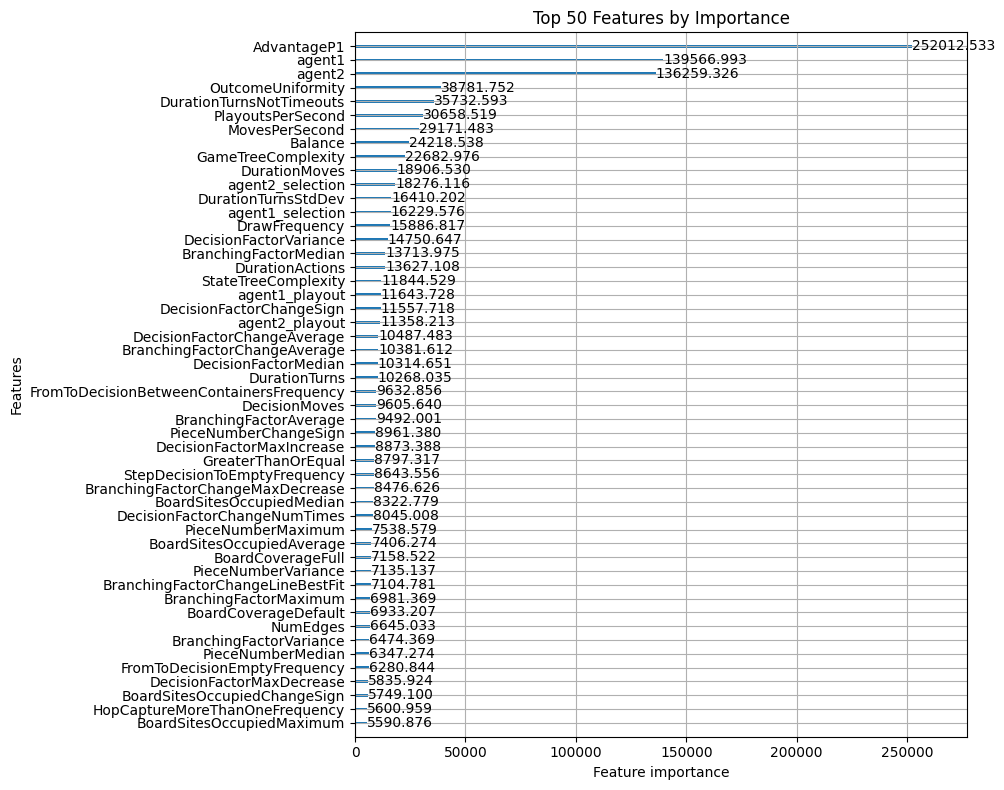

Fold 1 - RMSE: 0.41337329991068744
Fold 2


[100]	valid_0's rmse: 0.463844


[200]	valid_0's rmse: 0.442119


[300]	valid_0's rmse: 0.433142


[400]	valid_0's rmse: 0.427118


[500]	valid_0's rmse: 0.423728


[600]	valid_0's rmse: 0.421501


[700]	valid_0's rmse: 0.420107


[800]	valid_0's rmse: 0.418169


[900]	valid_0's rmse: 0.416438


[1000]	valid_0's rmse: 0.415339


[1100]	valid_0's rmse: 0.41451


[1200]	valid_0's rmse: 0.413664


[1300]	valid_0's rmse: 0.412552


[1400]	valid_0's rmse: 0.411844


[1500]	valid_0's rmse: 0.411189


[1600]	valid_0's rmse: 0.410755


[1700]	valid_0's rmse: 0.410355


[1800]	valid_0's rmse: 0.40993


[1900]	valid_0's rmse: 0.409476


[2000]	valid_0's rmse: 0.409158


[2100]	valid_0's rmse: 0.40898


[2200]	valid_0's rmse: 0.408682


[2300]	valid_0's rmse: 0.408325


[2400]	valid_0's rmse: 0.40803


[2500]	valid_0's rmse: 0.407689


[2600]	valid_0's rmse: 0.407484


[2700]	valid_0's rmse: 0.407298


[2800]	valid_0's rmse: 0.407143


[2900]	valid_0's rmse: 0.406964


[3000]	valid_0's rmse: 0.406657


[3100]	valid_0's rmse: 0.406584


[3200]	valid_0's rmse: 0.406482


[3300]	valid_0's rmse: 0.406259


[3400]	valid_0's rmse: 0.406065


[3500]	valid_0's rmse: 0.405972


[3600]	valid_0's rmse: 0.405835


[3700]	valid_0's rmse: 0.405755


[3800]	valid_0's rmse: 0.405642


[3900]	valid_0's rmse: 0.405546


[4000]	valid_0's rmse: 0.405492


[4100]	valid_0's rmse: 0.405463


[4200]	valid_0's rmse: 0.405398


[4300]	valid_0's rmse: 0.405422


[4400]	valid_0's rmse: 0.405371


[4500]	valid_0's rmse: 0.405315


[4600]	valid_0's rmse: 0.405227


[4700]	valid_0's rmse: 0.405092


[4800]	valid_0's rmse: 0.404907


[4900]	valid_0's rmse: 0.404905


[5000]	valid_0's rmse: 0.404942


[5100]	valid_0's rmse: 0.404895


[5200]	valid_0's rmse: 0.404829


[5300]	valid_0's rmse: 0.404793


[5400]	valid_0's rmse: 0.404789


[5500]	valid_0's rmse: 0.40476


[5600]	valid_0's rmse: 0.404694


[5700]	valid_0's rmse: 0.404644


[5800]	valid_0's rmse: 0.404661


[5900]	valid_0's rmse: 0.404592


[6000]	valid_0's rmse: 0.404554


[6100]	valid_0's rmse: 0.40451


[6200]	valid_0's rmse: 0.404478


[6300]	valid_0's rmse: 0.404497


[6400]	valid_0's rmse: 0.40456


[6500]	valid_0's rmse: 0.404549


[6600]	valid_0's rmse: 0.404483


[6700]	valid_0's rmse: 0.404465


[6800]	valid_0's rmse: 0.404405


[6900]	valid_0's rmse: 0.404412


[7000]	valid_0's rmse: 0.404391


[7100]	valid_0's rmse: 0.404408


[7200]	valid_0's rmse: 0.404443


[7300]	valid_0's rmse: 0.404433


[7400]	valid_0's rmse: 0.40447


[7500]	valid_0's rmse: 0.404474


[7600]	valid_0's rmse: 0.40447


[7700]	valid_0's rmse: 0.404475


[7800]	valid_0's rmse: 0.404442


[7900]	valid_0's rmse: 0.404469


[8000]	valid_0's rmse: 0.404449


[8100]	valid_0's rmse: 0.404466


[8200]	valid_0's rmse: 0.404401


[8300]	valid_0's rmse: 0.404467


[8400]	valid_0's rmse: 0.404454


[8500]	valid_0's rmse: 0.404477


[8600]	valid_0's rmse: 0.404399


[8700]	valid_0's rmse: 0.404435


[8800]	valid_0's rmse: 0.404466


[8900]	valid_0's rmse: 0.404441


[9000]	valid_0's rmse: 0.404418


[9100]	valid_0's rmse: 0.404358


[9200]	valid_0's rmse: 0.404347


[9300]	valid_0's rmse: 0.404303


[9400]	valid_0's rmse: 0.40426


[9500]	valid_0's rmse: 0.40422


[9600]	valid_0's rmse: 0.40425


[9700]	valid_0's rmse: 0.404304


[9800]	valid_0's rmse: 0.404307


[9900]	valid_0's rmse: 0.404331


[10000]	valid_0's rmse: 0.404321


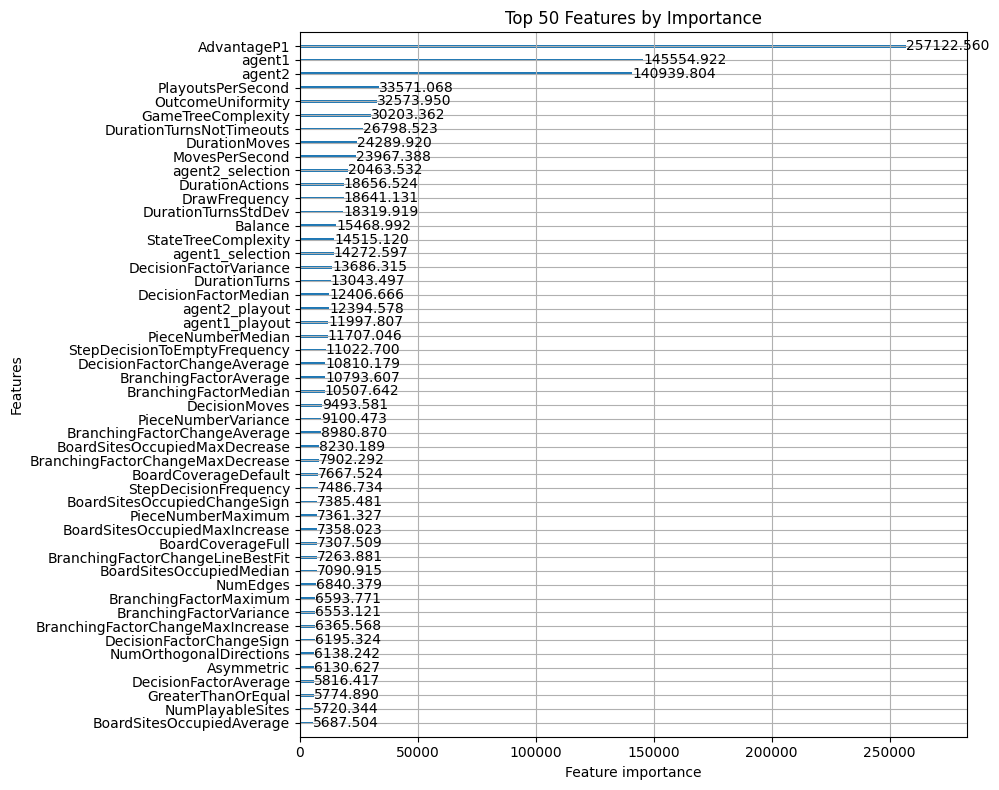

Fold 2 - RMSE: 0.40370715843033544
Fold 3


[100]	valid_0's rmse: 0.525284


[200]	valid_0's rmse: 0.498923


[300]	valid_0's rmse: 0.485593


[400]	valid_0's rmse: 0.4778


[500]	valid_0's rmse: 0.471998


[600]	valid_0's rmse: 0.467495


[700]	valid_0's rmse: 0.463808


[800]	valid_0's rmse: 0.460049


[900]	valid_0's rmse: 0.457384


[1000]	valid_0's rmse: 0.455379


[1100]	valid_0's rmse: 0.453383


[1200]	valid_0's rmse: 0.45199


[1300]	valid_0's rmse: 0.450625


[1400]	valid_0's rmse: 0.449587


[1500]	valid_0's rmse: 0.448625


[1600]	valid_0's rmse: 0.447721


[1700]	valid_0's rmse: 0.446928


[1800]	valid_0's rmse: 0.446321


[1900]	valid_0's rmse: 0.44568


[2000]	valid_0's rmse: 0.445023


[2100]	valid_0's rmse: 0.444651


[2200]	valid_0's rmse: 0.444121


[2300]	valid_0's rmse: 0.443635


[2400]	valid_0's rmse: 0.443221


[2500]	valid_0's rmse: 0.442929


[2600]	valid_0's rmse: 0.442521


[2700]	valid_0's rmse: 0.442159


[2800]	valid_0's rmse: 0.441816


[2900]	valid_0's rmse: 0.441497


[3000]	valid_0's rmse: 0.44114


[3100]	valid_0's rmse: 0.440959


[3200]	valid_0's rmse: 0.440742


[3300]	valid_0's rmse: 0.440463


[3400]	valid_0's rmse: 0.440258


[3500]	valid_0's rmse: 0.440029


[3600]	valid_0's rmse: 0.439837


[3700]	valid_0's rmse: 0.439698


[3800]	valid_0's rmse: 0.439472


[3900]	valid_0's rmse: 0.439233


[4000]	valid_0's rmse: 0.439081


[4100]	valid_0's rmse: 0.438887


[4200]	valid_0's rmse: 0.43874


[4300]	valid_0's rmse: 0.438483


[4400]	valid_0's rmse: 0.438362


[4500]	valid_0's rmse: 0.438186


[4600]	valid_0's rmse: 0.438


[4700]	valid_0's rmse: 0.437954


[4800]	valid_0's rmse: 0.437869


[4900]	valid_0's rmse: 0.437749


[5000]	valid_0's rmse: 0.437627


[5100]	valid_0's rmse: 0.437489


[5200]	valid_0's rmse: 0.437389


[5300]	valid_0's rmse: 0.437285


[5400]	valid_0's rmse: 0.43707


[5500]	valid_0's rmse: 0.436917


[5600]	valid_0's rmse: 0.436781


[5700]	valid_0's rmse: 0.43676


[5800]	valid_0's rmse: 0.436685


[5900]	valid_0's rmse: 0.436608


[6000]	valid_0's rmse: 0.436542


[6100]	valid_0's rmse: 0.436349


[6200]	valid_0's rmse: 0.436221


[6300]	valid_0's rmse: 0.436131


[6400]	valid_0's rmse: 0.436013


[6500]	valid_0's rmse: 0.435991


[6600]	valid_0's rmse: 0.435901


[6700]	valid_0's rmse: 0.435916


[6800]	valid_0's rmse: 0.435873


[6900]	valid_0's rmse: 0.435842


[7000]	valid_0's rmse: 0.435765


[7100]	valid_0's rmse: 0.435668


[7200]	valid_0's rmse: 0.43559


[7300]	valid_0's rmse: 0.435628


[7400]	valid_0's rmse: 0.435545


[7500]	valid_0's rmse: 0.435466


[7600]	valid_0's rmse: 0.435432


[7700]	valid_0's rmse: 0.435357


[7800]	valid_0's rmse: 0.435356


[7900]	valid_0's rmse: 0.435346


[8000]	valid_0's rmse: 0.435273


[8100]	valid_0's rmse: 0.4352


[8200]	valid_0's rmse: 0.435136


[8300]	valid_0's rmse: 0.435136


[8400]	valid_0's rmse: 0.435096


[8500]	valid_0's rmse: 0.43514


[8600]	valid_0's rmse: 0.435072


[8700]	valid_0's rmse: 0.435009


[8800]	valid_0's rmse: 0.434983


[8900]	valid_0's rmse: 0.434947


[9000]	valid_0's rmse: 0.434917


[9100]	valid_0's rmse: 0.434816


[9200]	valid_0's rmse: 0.43473


[9300]	valid_0's rmse: 0.434691


[9400]	valid_0's rmse: 0.434619


[9500]	valid_0's rmse: 0.434613


[9600]	valid_0's rmse: 0.434602


[9700]	valid_0's rmse: 0.434533


[9800]	valid_0's rmse: 0.434511


[9900]	valid_0's rmse: 0.434499


[10000]	valid_0's rmse: 0.43453


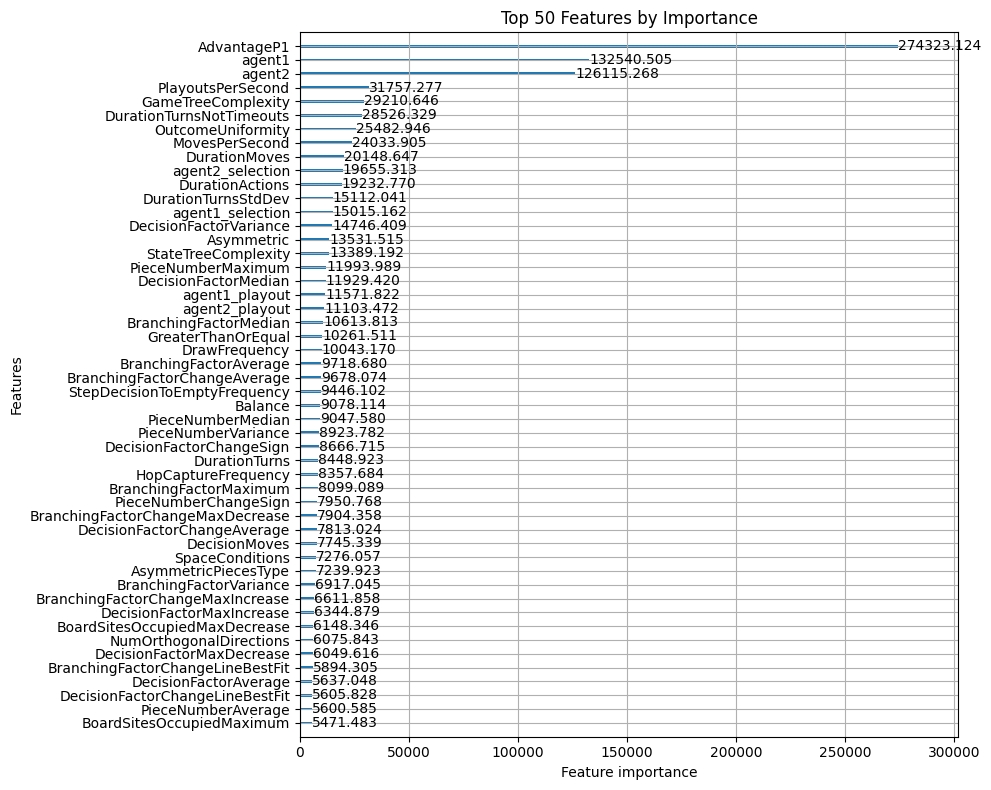

Fold 3 - RMSE: 0.4336697167466937
Fold 4


[100]	valid_0's rmse: 0.52114


[200]	valid_0's rmse: 0.4967


[300]	valid_0's rmse: 0.484799


[400]	valid_0's rmse: 0.477765


[500]	valid_0's rmse: 0.472234


[600]	valid_0's rmse: 0.468988


[700]	valid_0's rmse: 0.46615


[800]	valid_0's rmse: 0.46403


[900]	valid_0's rmse: 0.462119


[1000]	valid_0's rmse: 0.460313


[1100]	valid_0's rmse: 0.458715


[1200]	valid_0's rmse: 0.457469


[1300]	valid_0's rmse: 0.456302


[1400]	valid_0's rmse: 0.455495


[1500]	valid_0's rmse: 0.454794


[1600]	valid_0's rmse: 0.453856


[1700]	valid_0's rmse: 0.453144


[1800]	valid_0's rmse: 0.452536


[1900]	valid_0's rmse: 0.451879


[2000]	valid_0's rmse: 0.451489


[2100]	valid_0's rmse: 0.451032


[2200]	valid_0's rmse: 0.450634


[2300]	valid_0's rmse: 0.450265


[2400]	valid_0's rmse: 0.449804


[2500]	valid_0's rmse: 0.449533


[2600]	valid_0's rmse: 0.449106


[2700]	valid_0's rmse: 0.448811


[2800]	valid_0's rmse: 0.448514


[2900]	valid_0's rmse: 0.448144


[3000]	valid_0's rmse: 0.44801


[3100]	valid_0's rmse: 0.447659


[3200]	valid_0's rmse: 0.447452


[3300]	valid_0's rmse: 0.447145


[3400]	valid_0's rmse: 0.44711


[3500]	valid_0's rmse: 0.446788


[3600]	valid_0's rmse: 0.446655


[3700]	valid_0's rmse: 0.446449


[3800]	valid_0's rmse: 0.446321


[3900]	valid_0's rmse: 0.446053


[4000]	valid_0's rmse: 0.446027


[4100]	valid_0's rmse: 0.44589


[4200]	valid_0's rmse: 0.445634


[4300]	valid_0's rmse: 0.445501


[4400]	valid_0's rmse: 0.445407


[4500]	valid_0's rmse: 0.445309


[4600]	valid_0's rmse: 0.445141


[4700]	valid_0's rmse: 0.445079


[4800]	valid_0's rmse: 0.445081


[4900]	valid_0's rmse: 0.44506


[5000]	valid_0's rmse: 0.445079


[5100]	valid_0's rmse: 0.444906


[5200]	valid_0's rmse: 0.444799


[5300]	valid_0's rmse: 0.444703


[5400]	valid_0's rmse: 0.444651


[5500]	valid_0's rmse: 0.444558


[5600]	valid_0's rmse: 0.444501


[5700]	valid_0's rmse: 0.444423


[5800]	valid_0's rmse: 0.444334


[5900]	valid_0's rmse: 0.444263


[6000]	valid_0's rmse: 0.444151


[6100]	valid_0's rmse: 0.444103


[6200]	valid_0's rmse: 0.444086


[6300]	valid_0's rmse: 0.444056


[6400]	valid_0's rmse: 0.443993


[6500]	valid_0's rmse: 0.443988


[6600]	valid_0's rmse: 0.443904


[6700]	valid_0's rmse: 0.443818


[6800]	valid_0's rmse: 0.443756


[6900]	valid_0's rmse: 0.443762


[7000]	valid_0's rmse: 0.443685


[7100]	valid_0's rmse: 0.443657


[7200]	valid_0's rmse: 0.443596


[7300]	valid_0's rmse: 0.443486


[7400]	valid_0's rmse: 0.443409


[7500]	valid_0's rmse: 0.443407


[7600]	valid_0's rmse: 0.443412


[7700]	valid_0's rmse: 0.443347


[7800]	valid_0's rmse: 0.44336


[7900]	valid_0's rmse: 0.443306


[8000]	valid_0's rmse: 0.443259


[8100]	valid_0's rmse: 0.443143


[8200]	valid_0's rmse: 0.443085


[8300]	valid_0's rmse: 0.443039


[8400]	valid_0's rmse: 0.442957


[8500]	valid_0's rmse: 0.442989


[8600]	valid_0's rmse: 0.442934


[8700]	valid_0's rmse: 0.442945


[8800]	valid_0's rmse: 0.442932


[8900]	valid_0's rmse: 0.442939


[9000]	valid_0's rmse: 0.442953


[9100]	valid_0's rmse: 0.442872


[9200]	valid_0's rmse: 0.442833


[9300]	valid_0's rmse: 0.442848


[9400]	valid_0's rmse: 0.442783


[9500]	valid_0's rmse: 0.442726


[9600]	valid_0's rmse: 0.442717


[9700]	valid_0's rmse: 0.442734


[9800]	valid_0's rmse: 0.442745


[9900]	valid_0's rmse: 0.442691


[10000]	valid_0's rmse: 0.442657


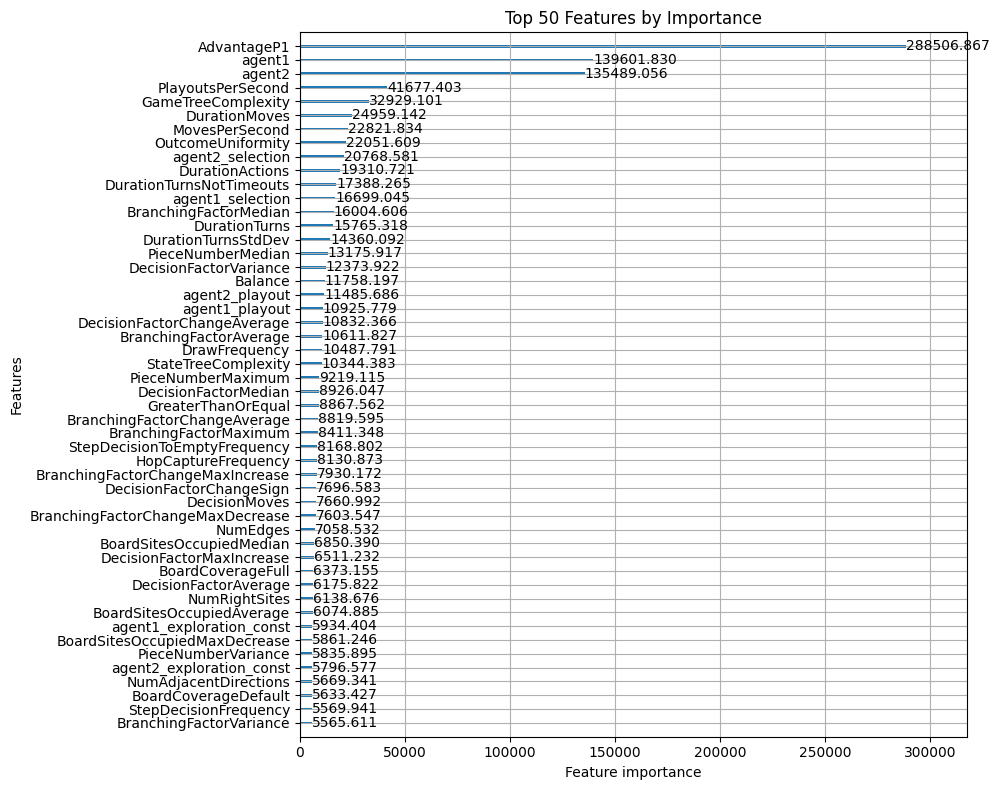

Fold 4 - RMSE: 0.4422631763663384
Fold 5


[100]	valid_0's rmse: 0.52458


[200]	valid_0's rmse: 0.502216


[300]	valid_0's rmse: 0.488359


[400]	valid_0's rmse: 0.480289


[500]	valid_0's rmse: 0.474937


[600]	valid_0's rmse: 0.470103


[700]	valid_0's rmse: 0.466259


[800]	valid_0's rmse: 0.463424


[900]	valid_0's rmse: 0.460618


[1000]	valid_0's rmse: 0.458749


[1100]	valid_0's rmse: 0.45681


[1200]	valid_0's rmse: 0.455405


[1300]	valid_0's rmse: 0.454075


[1400]	valid_0's rmse: 0.452877


[1500]	valid_0's rmse: 0.451777


[1600]	valid_0's rmse: 0.450973


[1700]	valid_0's rmse: 0.449924


[1800]	valid_0's rmse: 0.449167


[1900]	valid_0's rmse: 0.448432


[2000]	valid_0's rmse: 0.447757


[2100]	valid_0's rmse: 0.447238


[2200]	valid_0's rmse: 0.4468


[2300]	valid_0's rmse: 0.446222


[2400]	valid_0's rmse: 0.445756


[2500]	valid_0's rmse: 0.445178


[2600]	valid_0's rmse: 0.444871


[2700]	valid_0's rmse: 0.444531


[2800]	valid_0's rmse: 0.444201


[2900]	valid_0's rmse: 0.443912


[3000]	valid_0's rmse: 0.44362


[3100]	valid_0's rmse: 0.443326


[3200]	valid_0's rmse: 0.443168


[3300]	valid_0's rmse: 0.442982


[3400]	valid_0's rmse: 0.442712


[3500]	valid_0's rmse: 0.442435


[3600]	valid_0's rmse: 0.442194


[3700]	valid_0's rmse: 0.441987


[3800]	valid_0's rmse: 0.441813


[3900]	valid_0's rmse: 0.441658


[4000]	valid_0's rmse: 0.441452


[4100]	valid_0's rmse: 0.441239


[4200]	valid_0's rmse: 0.441159


[4300]	valid_0's rmse: 0.44102


[4400]	valid_0's rmse: 0.440808


[4500]	valid_0's rmse: 0.440613


[4600]	valid_0's rmse: 0.440509


[4700]	valid_0's rmse: 0.440455


[4800]	valid_0's rmse: 0.440294


[4900]	valid_0's rmse: 0.440197


[5000]	valid_0's rmse: 0.440121


[5100]	valid_0's rmse: 0.439983


[5200]	valid_0's rmse: 0.439913


[5300]	valid_0's rmse: 0.439765


[5400]	valid_0's rmse: 0.439692


[5500]	valid_0's rmse: 0.439629


[5600]	valid_0's rmse: 0.439525


[5700]	valid_0's rmse: 0.439352


[5800]	valid_0's rmse: 0.439254


[5900]	valid_0's rmse: 0.439205


[6000]	valid_0's rmse: 0.439093


[6100]	valid_0's rmse: 0.439023


[6200]	valid_0's rmse: 0.438955


[6300]	valid_0's rmse: 0.438908


[6400]	valid_0's rmse: 0.438861


[6500]	valid_0's rmse: 0.438787


[6600]	valid_0's rmse: 0.438744


[6700]	valid_0's rmse: 0.438647


[6800]	valid_0's rmse: 0.438573


[6900]	valid_0's rmse: 0.43849


[7000]	valid_0's rmse: 0.438431


[7100]	valid_0's rmse: 0.438332


[7200]	valid_0's rmse: 0.438286


[7300]	valid_0's rmse: 0.438236


[7400]	valid_0's rmse: 0.438202


[7500]	valid_0's rmse: 0.438158


[7600]	valid_0's rmse: 0.438098


[7700]	valid_0's rmse: 0.438144


[7800]	valid_0's rmse: 0.43808


[7900]	valid_0's rmse: 0.438087


[8000]	valid_0's rmse: 0.438021


[8100]	valid_0's rmse: 0.437929


[8200]	valid_0's rmse: 0.437966


[8300]	valid_0's rmse: 0.43793


[8400]	valid_0's rmse: 0.437896


[8500]	valid_0's rmse: 0.437866


[8600]	valid_0's rmse: 0.437791


[8700]	valid_0's rmse: 0.437741


[8800]	valid_0's rmse: 0.43768


[8900]	valid_0's rmse: 0.437642


[9000]	valid_0's rmse: 0.437555


[9100]	valid_0's rmse: 0.437511


[9200]	valid_0's rmse: 0.437512


[9300]	valid_0's rmse: 0.437494


[9400]	valid_0's rmse: 0.43745


[9500]	valid_0's rmse: 0.437447


[9600]	valid_0's rmse: 0.437452


[9700]	valid_0's rmse: 0.437432


[9800]	valid_0's rmse: 0.437403


[9900]	valid_0's rmse: 0.437416


[10000]	valid_0's rmse: 0.437421


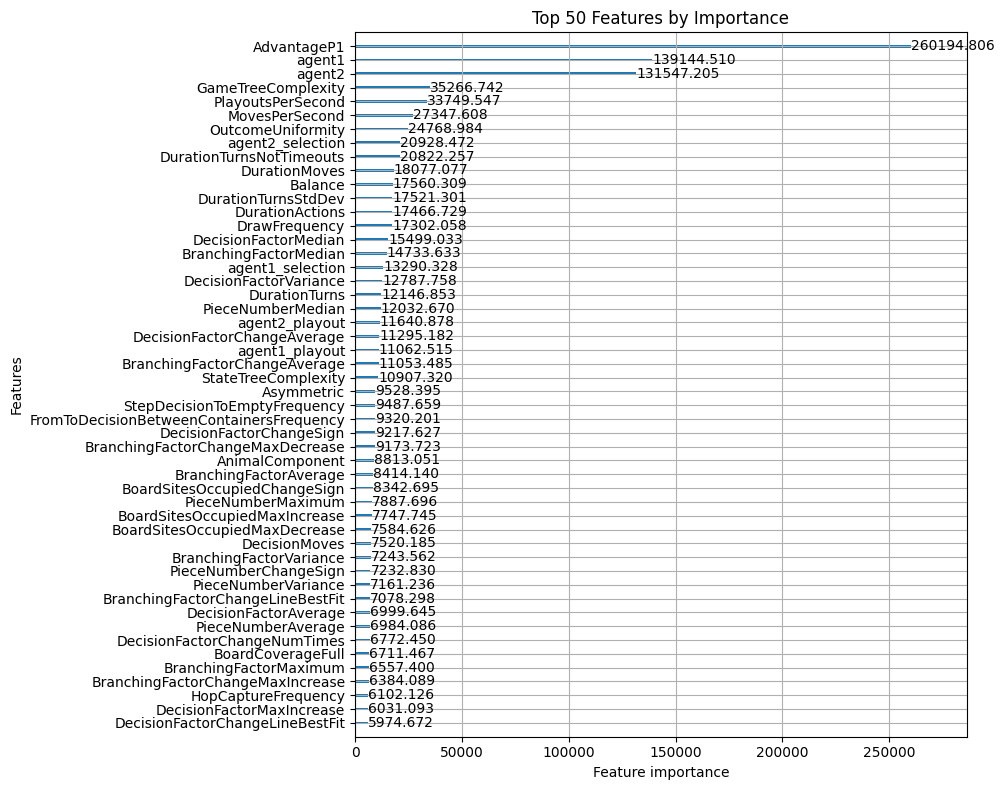

Fold 5 - RMSE: 0.43676084566519335
List of oof scores: [0.41337329991068744, 0.40370715843033544, 0.4336697167466937, 0.4422631763663384, 0.43676084566519335]
Average oof score: 0.42595483942384965


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.510559


[200]	valid_0's rmse: 0.485587


[300]	valid_0's rmse: 0.47385


[400]	valid_0's rmse: 0.467034


[500]	valid_0's rmse: 0.462827


[600]	valid_0's rmse: 0.459182


[700]	valid_0's rmse: 0.456836


[800]	valid_0's rmse: 0.454115


[900]	valid_0's rmse: 0.452279


[1000]	valid_0's rmse: 0.450868


[1100]	valid_0's rmse: 0.449564


[1200]	valid_0's rmse: 0.448102


[1300]	valid_0's rmse: 0.447114


[1400]	valid_0's rmse: 0.446152


[1500]	valid_0's rmse: 0.445391


[1600]	valid_0's rmse: 0.444838


[1700]	valid_0's rmse: 0.444135


[1800]	valid_0's rmse: 0.443558


[1900]	valid_0's rmse: 0.443028


[2000]	valid_0's rmse: 0.442672


[2100]	valid_0's rmse: 0.442208


[2200]	valid_0's rmse: 0.441807


[2300]	valid_0's rmse: 0.441363


[2400]	valid_0's rmse: 0.44091


[2500]	valid_0's rmse: 0.440585


[2600]	valid_0's rmse: 0.440394


[2700]	valid_0's rmse: 0.440165


[2800]	valid_0's rmse: 0.439883


[2900]	valid_0's rmse: 0.439691


[3000]	valid_0's rmse: 0.439375


[3100]	valid_0's rmse: 0.439093


[3200]	valid_0's rmse: 0.438933


[3300]	valid_0's rmse: 0.438676


[3400]	valid_0's rmse: 0.438435


[3500]	valid_0's rmse: 0.438224


[3600]	valid_0's rmse: 0.437956


[3700]	valid_0's rmse: 0.437778


[3800]	valid_0's rmse: 0.437658


[3900]	valid_0's rmse: 0.43755


[4000]	valid_0's rmse: 0.43741


[4100]	valid_0's rmse: 0.437283


[4200]	valid_0's rmse: 0.437278


[4300]	valid_0's rmse: 0.437201


[4400]	valid_0's rmse: 0.437172


[4500]	valid_0's rmse: 0.437044


[4600]	valid_0's rmse: 0.436955


[4700]	valid_0's rmse: 0.436858


[4800]	valid_0's rmse: 0.43685


[4900]	valid_0's rmse: 0.436676


[5000]	valid_0's rmse: 0.436574


[5100]	valid_0's rmse: 0.436551


[5200]	valid_0's rmse: 0.43649


[5300]	valid_0's rmse: 0.436386


[5400]	valid_0's rmse: 0.436336


[5500]	valid_0's rmse: 0.436151


[5600]	valid_0's rmse: 0.436103


[5700]	valid_0's rmse: 0.436064


[5800]	valid_0's rmse: 0.436019


[5900]	valid_0's rmse: 0.435929


[6000]	valid_0's rmse: 0.435869


[6100]	valid_0's rmse: 0.43575


[6200]	valid_0's rmse: 0.435683


[6300]	valid_0's rmse: 0.435577


[6400]	valid_0's rmse: 0.435627


[6500]	valid_0's rmse: 0.435573


[6600]	valid_0's rmse: 0.435494


[6700]	valid_0's rmse: 0.435488


[6800]	valid_0's rmse: 0.435405


[6900]	valid_0's rmse: 0.435317


[7000]	valid_0's rmse: 0.435244


[7100]	valid_0's rmse: 0.435288


[7200]	valid_0's rmse: 0.435219


[7300]	valid_0's rmse: 0.435134


[7400]	valid_0's rmse: 0.435083


[7500]	valid_0's rmse: 0.435047


[7600]	valid_0's rmse: 0.435024


[7700]	valid_0's rmse: 0.434981


[7800]	valid_0's rmse: 0.434963


[7900]	valid_0's rmse: 0.434991


[8000]	valid_0's rmse: 0.435006


[8100]	valid_0's rmse: 0.434944


[8200]	valid_0's rmse: 0.434894


[8300]	valid_0's rmse: 0.434887


[8400]	valid_0's rmse: 0.434872


[8500]	valid_0's rmse: 0.434849


[8600]	valid_0's rmse: 0.434846


[8700]	valid_0's rmse: 0.434812


[8800]	valid_0's rmse: 0.434821


[8900]	valid_0's rmse: 0.434811


[9000]	valid_0's rmse: 0.434858


[9100]	valid_0's rmse: 0.434861


[9200]	valid_0's rmse: 0.434885


[9300]	valid_0's rmse: 0.434845


[9400]	valid_0's rmse: 0.434829


[9500]	valid_0's rmse: 0.4348


[9600]	valid_0's rmse: 0.434744


[9700]	valid_0's rmse: 0.434705


[9800]	valid_0's rmse: 0.434633


[9900]	valid_0's rmse: 0.434597


[10000]	valid_0's rmse: 0.434581


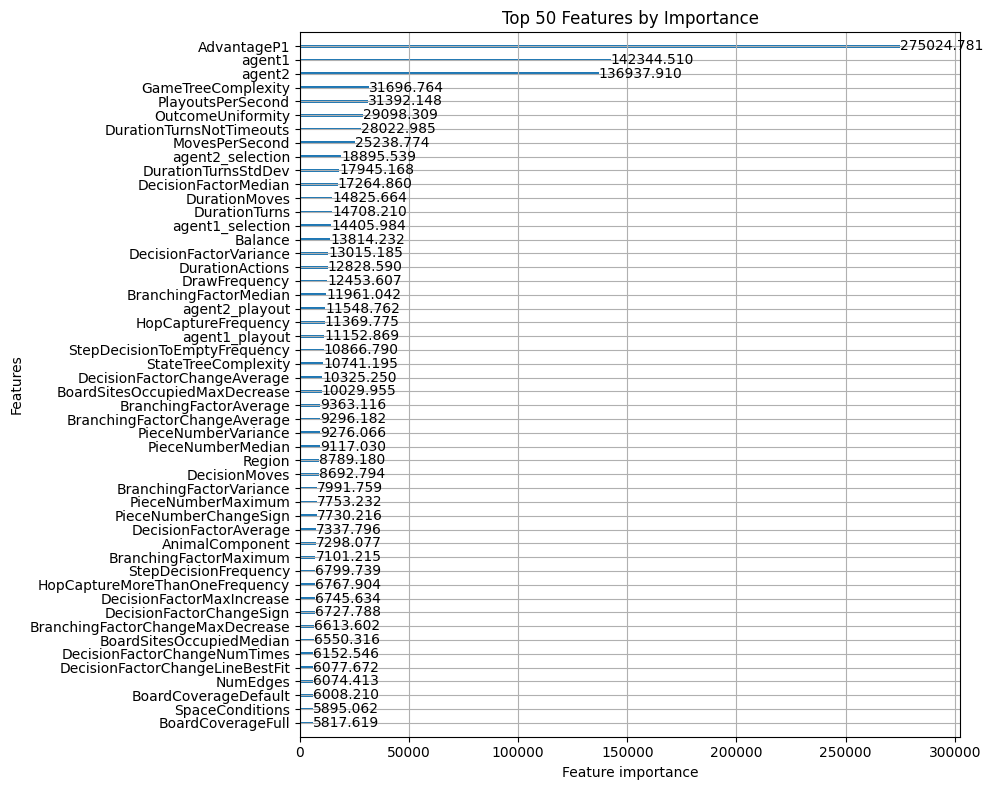

Fold 1 - RMSE: 0.4340318675317364
Fold 2


[100]	valid_0's rmse: 0.509314


[200]	valid_0's rmse: 0.486158


[300]	valid_0's rmse: 0.471757


[400]	valid_0's rmse: 0.462925


[500]	valid_0's rmse: 0.457461


[600]	valid_0's rmse: 0.452449


[700]	valid_0's rmse: 0.448532


[800]	valid_0's rmse: 0.445699


[900]	valid_0's rmse: 0.443083


[1000]	valid_0's rmse: 0.441134


[1100]	valid_0's rmse: 0.439077


[1200]	valid_0's rmse: 0.437371


[1300]	valid_0's rmse: 0.435886


[1400]	valid_0's rmse: 0.434552


[1500]	valid_0's rmse: 0.433164


[1600]	valid_0's rmse: 0.431946


[1700]	valid_0's rmse: 0.43103


[1800]	valid_0's rmse: 0.430144


[1900]	valid_0's rmse: 0.429527


[2000]	valid_0's rmse: 0.428672


[2100]	valid_0's rmse: 0.428093


[2200]	valid_0's rmse: 0.427532


[2300]	valid_0's rmse: 0.426997


[2400]	valid_0's rmse: 0.426461


[2500]	valid_0's rmse: 0.425908


[2600]	valid_0's rmse: 0.425661


[2700]	valid_0's rmse: 0.425257


[2800]	valid_0's rmse: 0.424915


[2900]	valid_0's rmse: 0.42466


[3000]	valid_0's rmse: 0.424349


[3100]	valid_0's rmse: 0.424063


[3200]	valid_0's rmse: 0.423774


[3300]	valid_0's rmse: 0.423497


[3400]	valid_0's rmse: 0.423039


[3500]	valid_0's rmse: 0.422779


[3600]	valid_0's rmse: 0.422462


[3700]	valid_0's rmse: 0.422308


[3800]	valid_0's rmse: 0.422157


[3900]	valid_0's rmse: 0.421838


[4000]	valid_0's rmse: 0.421614


[4100]	valid_0's rmse: 0.421498


[4200]	valid_0's rmse: 0.421274


[4300]	valid_0's rmse: 0.420983


[4400]	valid_0's rmse: 0.420765


[4500]	valid_0's rmse: 0.420561


[4600]	valid_0's rmse: 0.42042


[4700]	valid_0's rmse: 0.420229


[4800]	valid_0's rmse: 0.420116


[4900]	valid_0's rmse: 0.419973


[5000]	valid_0's rmse: 0.419903


[5100]	valid_0's rmse: 0.419791


[5200]	valid_0's rmse: 0.41965


[5300]	valid_0's rmse: 0.419526


[5400]	valid_0's rmse: 0.419465


[5500]	valid_0's rmse: 0.419378


[5600]	valid_0's rmse: 0.419207


[5700]	valid_0's rmse: 0.419082


[5800]	valid_0's rmse: 0.419016


[5900]	valid_0's rmse: 0.418899


[6000]	valid_0's rmse: 0.418857


[6100]	valid_0's rmse: 0.418745


[6200]	valid_0's rmse: 0.418677


[6300]	valid_0's rmse: 0.418587


[6400]	valid_0's rmse: 0.418531


[6500]	valid_0's rmse: 0.418517


[6600]	valid_0's rmse: 0.418431


[6700]	valid_0's rmse: 0.418413


[6800]	valid_0's rmse: 0.418316


[6900]	valid_0's rmse: 0.418281


[7000]	valid_0's rmse: 0.418282


[7100]	valid_0's rmse: 0.418286


[7200]	valid_0's rmse: 0.418135


[7300]	valid_0's rmse: 0.417998


[7400]	valid_0's rmse: 0.418011


[7500]	valid_0's rmse: 0.417852


[7600]	valid_0's rmse: 0.417738


[7700]	valid_0's rmse: 0.417717


[7800]	valid_0's rmse: 0.417601


[7900]	valid_0's rmse: 0.417498


[8000]	valid_0's rmse: 0.417469


[8100]	valid_0's rmse: 0.417415


[8200]	valid_0's rmse: 0.41743


[8300]	valid_0's rmse: 0.417378


[8400]	valid_0's rmse: 0.41731


[8500]	valid_0's rmse: 0.417294


[8600]	valid_0's rmse: 0.41729


[8700]	valid_0's rmse: 0.417255


[8800]	valid_0's rmse: 0.417182


[8900]	valid_0's rmse: 0.417125


[9000]	valid_0's rmse: 0.417147


[9100]	valid_0's rmse: 0.4171


[9200]	valid_0's rmse: 0.417031


[9300]	valid_0's rmse: 0.417002


[9400]	valid_0's rmse: 0.416964


[9500]	valid_0's rmse: 0.416924


[9600]	valid_0's rmse: 0.416942


[9700]	valid_0's rmse: 0.41695


[9800]	valid_0's rmse: 0.416917


[9900]	valid_0's rmse: 0.416916


[10000]	valid_0's rmse: 0.416885


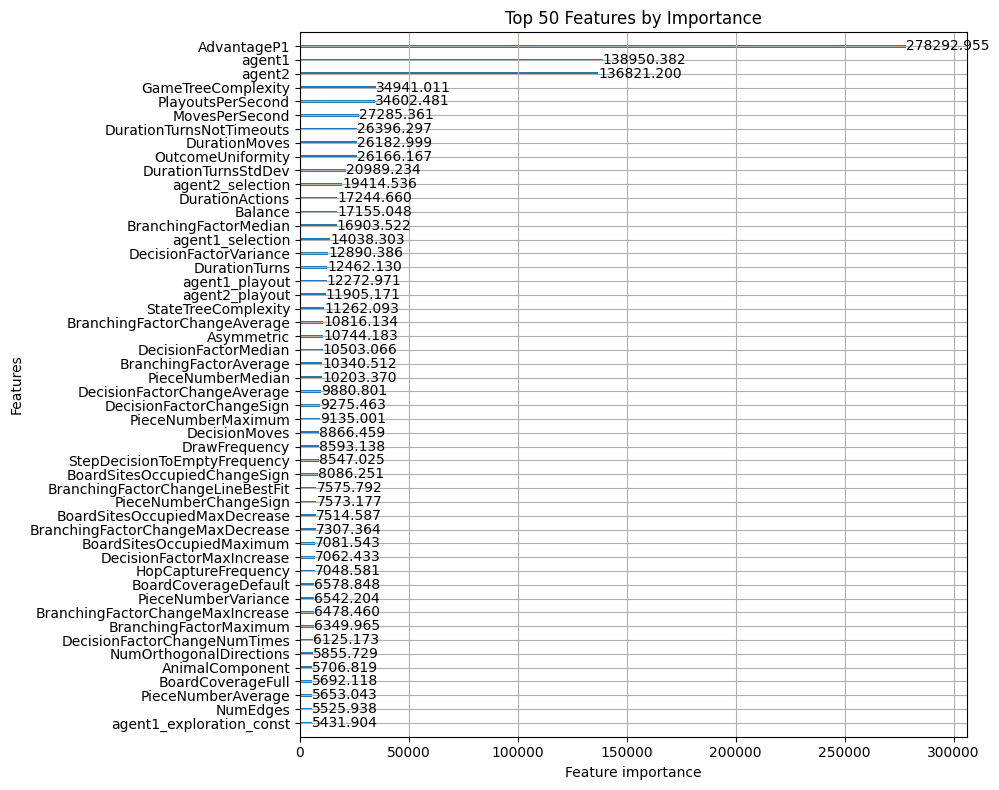

Fold 2 - RMSE: 0.4164862497948062
Fold 3


[100]	valid_0's rmse: 0.500557


[200]	valid_0's rmse: 0.472413


[300]	valid_0's rmse: 0.462546


[400]	valid_0's rmse: 0.456346


[500]	valid_0's rmse: 0.45228


[600]	valid_0's rmse: 0.449133


[700]	valid_0's rmse: 0.446574


[800]	valid_0's rmse: 0.444156


[900]	valid_0's rmse: 0.442427


[1000]	valid_0's rmse: 0.441007


[1100]	valid_0's rmse: 0.439713


[1200]	valid_0's rmse: 0.438476


[1300]	valid_0's rmse: 0.437496


[1400]	valid_0's rmse: 0.436507


[1500]	valid_0's rmse: 0.435634


[1600]	valid_0's rmse: 0.434961


[1700]	valid_0's rmse: 0.434406


[1800]	valid_0's rmse: 0.43381


[1900]	valid_0's rmse: 0.433355


[2000]	valid_0's rmse: 0.43289


[2100]	valid_0's rmse: 0.432397


[2200]	valid_0's rmse: 0.432142


[2300]	valid_0's rmse: 0.431757


[2400]	valid_0's rmse: 0.431389


[2500]	valid_0's rmse: 0.431003


[2600]	valid_0's rmse: 0.430751


[2700]	valid_0's rmse: 0.430424


[2800]	valid_0's rmse: 0.430194


[2900]	valid_0's rmse: 0.430011


[3000]	valid_0's rmse: 0.429801


[3100]	valid_0's rmse: 0.429482


[3200]	valid_0's rmse: 0.429375


[3300]	valid_0's rmse: 0.429263


[3400]	valid_0's rmse: 0.429038


[3500]	valid_0's rmse: 0.428753


[3600]	valid_0's rmse: 0.428731


[3700]	valid_0's rmse: 0.428629


[3800]	valid_0's rmse: 0.428555


[3900]	valid_0's rmse: 0.428451


[4000]	valid_0's rmse: 0.428273


[4100]	valid_0's rmse: 0.42813


[4200]	valid_0's rmse: 0.428028


[4300]	valid_0's rmse: 0.427887


[4400]	valid_0's rmse: 0.427661


[4500]	valid_0's rmse: 0.427494


[4600]	valid_0's rmse: 0.427389


[4700]	valid_0's rmse: 0.427257


[4800]	valid_0's rmse: 0.427212


[4900]	valid_0's rmse: 0.427103


[5000]	valid_0's rmse: 0.427032


[5100]	valid_0's rmse: 0.426948


[5200]	valid_0's rmse: 0.426855


[5300]	valid_0's rmse: 0.42675


[5400]	valid_0's rmse: 0.426737


[5500]	valid_0's rmse: 0.426672


[5600]	valid_0's rmse: 0.426638


[5700]	valid_0's rmse: 0.426597


[5800]	valid_0's rmse: 0.426535


[5900]	valid_0's rmse: 0.426502


[6000]	valid_0's rmse: 0.426452


[6100]	valid_0's rmse: 0.426402


[6200]	valid_0's rmse: 0.426432


[6300]	valid_0's rmse: 0.426275


[6400]	valid_0's rmse: 0.426276


[6500]	valid_0's rmse: 0.426177


[6600]	valid_0's rmse: 0.426125


[6700]	valid_0's rmse: 0.426117


[6800]	valid_0's rmse: 0.426076


[6900]	valid_0's rmse: 0.426057


[7000]	valid_0's rmse: 0.425963


[7100]	valid_0's rmse: 0.425943


[7200]	valid_0's rmse: 0.425918


[7300]	valid_0's rmse: 0.425906


[7400]	valid_0's rmse: 0.425851


[7500]	valid_0's rmse: 0.425817


[7600]	valid_0's rmse: 0.425775


[7700]	valid_0's rmse: 0.425624


[7800]	valid_0's rmse: 0.425586


[7900]	valid_0's rmse: 0.425547


[8000]	valid_0's rmse: 0.425544


[8100]	valid_0's rmse: 0.425495


[8200]	valid_0's rmse: 0.425461


[8300]	valid_0's rmse: 0.425459


[8400]	valid_0's rmse: 0.425529


[8500]	valid_0's rmse: 0.425453


[8600]	valid_0's rmse: 0.425456


[8700]	valid_0's rmse: 0.425478


[8800]	valid_0's rmse: 0.425461


[8900]	valid_0's rmse: 0.425446


[9000]	valid_0's rmse: 0.425371


[9100]	valid_0's rmse: 0.425362


[9200]	valid_0's rmse: 0.425364


[9300]	valid_0's rmse: 0.425318


[9400]	valid_0's rmse: 0.425324


[9500]	valid_0's rmse: 0.425306


[9600]	valid_0's rmse: 0.42532


[9700]	valid_0's rmse: 0.425328


[9800]	valid_0's rmse: 0.425304


[9900]	valid_0's rmse: 0.425304


[10000]	valid_0's rmse: 0.425282


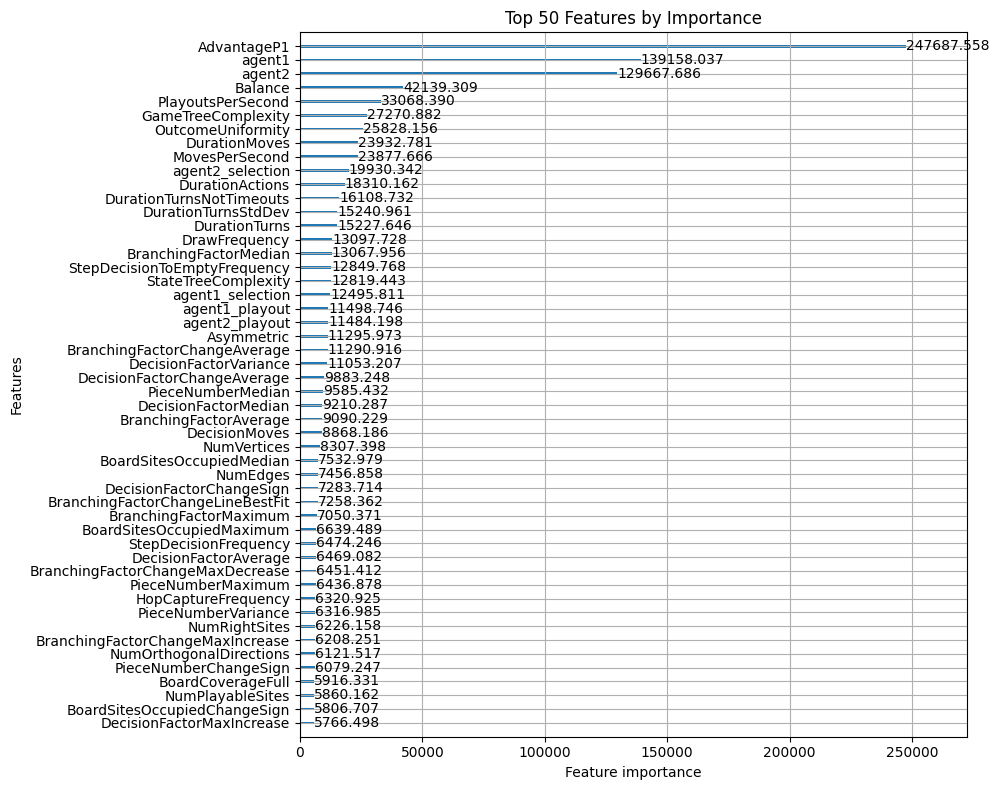

Fold 3 - RMSE: 0.42481736086199184
Fold 4


[100]	valid_0's rmse: 0.497813


[200]	valid_0's rmse: 0.470153


[300]	valid_0's rmse: 0.457609


[400]	valid_0's rmse: 0.449628


[500]	valid_0's rmse: 0.445171


[600]	valid_0's rmse: 0.441255


[700]	valid_0's rmse: 0.438123


[800]	valid_0's rmse: 0.435721


[900]	valid_0's rmse: 0.433583


[1000]	valid_0's rmse: 0.432037


[1100]	valid_0's rmse: 0.430615


[1200]	valid_0's rmse: 0.429509


[1300]	valid_0's rmse: 0.428631


[1400]	valid_0's rmse: 0.427705


[1500]	valid_0's rmse: 0.427058


[1600]	valid_0's rmse: 0.426245


[1700]	valid_0's rmse: 0.425622


[1800]	valid_0's rmse: 0.425121


[1900]	valid_0's rmse: 0.424587


[2000]	valid_0's rmse: 0.42408


[2100]	valid_0's rmse: 0.423797


[2200]	valid_0's rmse: 0.423358


[2300]	valid_0's rmse: 0.423157


[2400]	valid_0's rmse: 0.422923


[2500]	valid_0's rmse: 0.422654


[2600]	valid_0's rmse: 0.42236


[2700]	valid_0's rmse: 0.42202


[2800]	valid_0's rmse: 0.421716


[2900]	valid_0's rmse: 0.421484


[3000]	valid_0's rmse: 0.421253


[3100]	valid_0's rmse: 0.420954


[3200]	valid_0's rmse: 0.420855


[3300]	valid_0's rmse: 0.420646


[3400]	valid_0's rmse: 0.420419


[3500]	valid_0's rmse: 0.42032


[3600]	valid_0's rmse: 0.420192


[3700]	valid_0's rmse: 0.419925


[3800]	valid_0's rmse: 0.419841


[3900]	valid_0's rmse: 0.419646


[4000]	valid_0's rmse: 0.41957


[4100]	valid_0's rmse: 0.419533


[4200]	valid_0's rmse: 0.419489


[4300]	valid_0's rmse: 0.419437


[4400]	valid_0's rmse: 0.419331


[4500]	valid_0's rmse: 0.419238


[4600]	valid_0's rmse: 0.419107


[4700]	valid_0's rmse: 0.418993


[4800]	valid_0's rmse: 0.418884


[4900]	valid_0's rmse: 0.418781


[5000]	valid_0's rmse: 0.418736


[5100]	valid_0's rmse: 0.418573


[5200]	valid_0's rmse: 0.418528


[5300]	valid_0's rmse: 0.418526


[5400]	valid_0's rmse: 0.41849


[5500]	valid_0's rmse: 0.418442


[5600]	valid_0's rmse: 0.418387


[5700]	valid_0's rmse: 0.418379


[5800]	valid_0's rmse: 0.418257


[5900]	valid_0's rmse: 0.418223


[6000]	valid_0's rmse: 0.418127


[6100]	valid_0's rmse: 0.418067


[6200]	valid_0's rmse: 0.417983


[6300]	valid_0's rmse: 0.417967


[6400]	valid_0's rmse: 0.417965


[6500]	valid_0's rmse: 0.417911


[6600]	valid_0's rmse: 0.41786


[6700]	valid_0's rmse: 0.417793


[6800]	valid_0's rmse: 0.417767


[6900]	valid_0's rmse: 0.417735


[7000]	valid_0's rmse: 0.417738


[7100]	valid_0's rmse: 0.417764


[7200]	valid_0's rmse: 0.417773


[7300]	valid_0's rmse: 0.417809


[7400]	valid_0's rmse: 0.417774


[7500]	valid_0's rmse: 0.417739


[7600]	valid_0's rmse: 0.41772


[7700]	valid_0's rmse: 0.417697


[7800]	valid_0's rmse: 0.417673


[7900]	valid_0's rmse: 0.41767


[8000]	valid_0's rmse: 0.417673


[8100]	valid_0's rmse: 0.417647


[8200]	valid_0's rmse: 0.417582


[8300]	valid_0's rmse: 0.417594


[8400]	valid_0's rmse: 0.417577


[8500]	valid_0's rmse: 0.417518


[8600]	valid_0's rmse: 0.417509


[8700]	valid_0's rmse: 0.417423


[8800]	valid_0's rmse: 0.417431


[8900]	valid_0's rmse: 0.417416


[9000]	valid_0's rmse: 0.417372


[9100]	valid_0's rmse: 0.417367


[9200]	valid_0's rmse: 0.417353


[9300]	valid_0's rmse: 0.417314


[9400]	valid_0's rmse: 0.417298


[9500]	valid_0's rmse: 0.417251


[9600]	valid_0's rmse: 0.417233


[9700]	valid_0's rmse: 0.417212


[9800]	valid_0's rmse: 0.417222


[9900]	valid_0's rmse: 0.417213


[10000]	valid_0's rmse: 0.417247


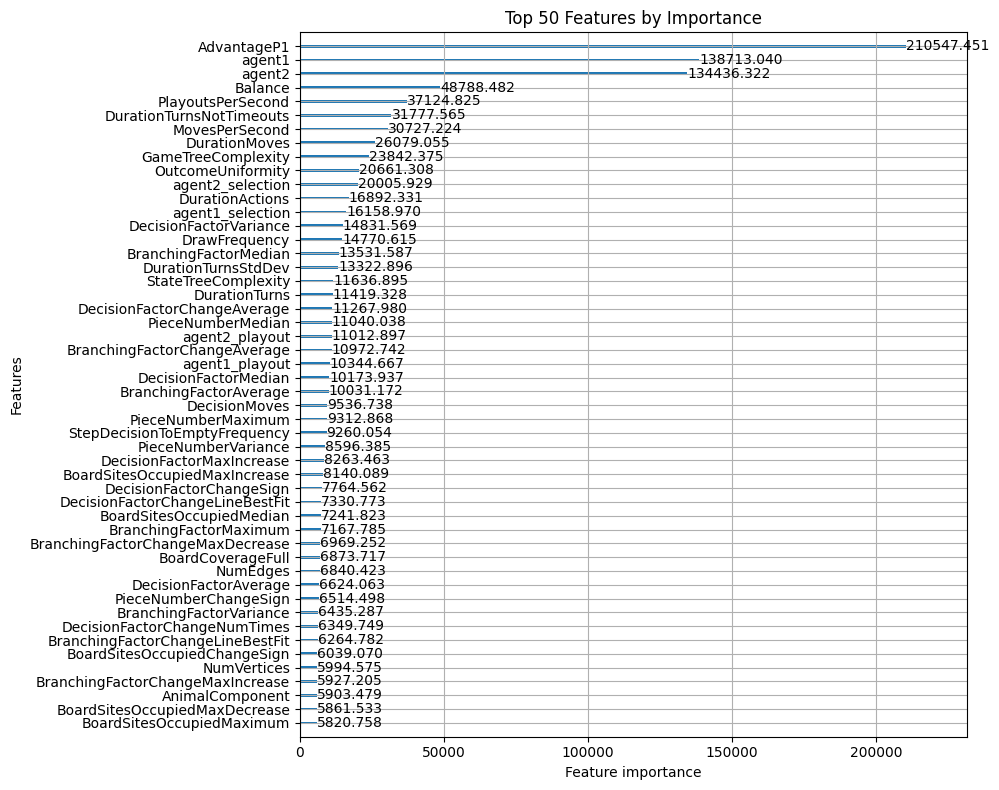

Fold 4 - RMSE: 0.41666961646885337
Fold 5


[100]	valid_0's rmse: 0.509737


[200]	valid_0's rmse: 0.488137


[300]	valid_0's rmse: 0.476814


[400]	valid_0's rmse: 0.470182


[500]	valid_0's rmse: 0.464414


[600]	valid_0's rmse: 0.46021


[700]	valid_0's rmse: 0.456756


[800]	valid_0's rmse: 0.453524


[900]	valid_0's rmse: 0.451115


[1000]	valid_0's rmse: 0.449019


[1100]	valid_0's rmse: 0.447271


[1200]	valid_0's rmse: 0.445634


[1300]	valid_0's rmse: 0.44417


[1400]	valid_0's rmse: 0.443007


[1500]	valid_0's rmse: 0.441904


[1600]	valid_0's rmse: 0.440894


[1700]	valid_0's rmse: 0.440122


[1800]	valid_0's rmse: 0.439422


[1900]	valid_0's rmse: 0.438741


[2000]	valid_0's rmse: 0.438133


[2100]	valid_0's rmse: 0.437524


[2200]	valid_0's rmse: 0.437064


[2300]	valid_0's rmse: 0.43667


[2400]	valid_0's rmse: 0.436237


[2500]	valid_0's rmse: 0.435741


[2600]	valid_0's rmse: 0.435291


[2700]	valid_0's rmse: 0.434872


[2800]	valid_0's rmse: 0.434493


[2900]	valid_0's rmse: 0.434136


[3000]	valid_0's rmse: 0.433949


[3100]	valid_0's rmse: 0.4338


[3200]	valid_0's rmse: 0.43348


[3300]	valid_0's rmse: 0.433286


[3400]	valid_0's rmse: 0.432901


[3500]	valid_0's rmse: 0.432693


[3600]	valid_0's rmse: 0.432537


[3700]	valid_0's rmse: 0.432285


[3800]	valid_0's rmse: 0.432078


[3900]	valid_0's rmse: 0.431915


[4000]	valid_0's rmse: 0.431758


[4100]	valid_0's rmse: 0.431444


[4200]	valid_0's rmse: 0.431329


[4300]	valid_0's rmse: 0.431157


[4400]	valid_0's rmse: 0.431012


[4500]	valid_0's rmse: 0.430853


[4600]	valid_0's rmse: 0.430781


[4700]	valid_0's rmse: 0.430677


[4800]	valid_0's rmse: 0.430562


[4900]	valid_0's rmse: 0.430529


[5000]	valid_0's rmse: 0.430403


[5100]	valid_0's rmse: 0.430262


[5200]	valid_0's rmse: 0.430086


[5300]	valid_0's rmse: 0.429956


[5400]	valid_0's rmse: 0.429869


[5500]	valid_0's rmse: 0.429759


[5600]	valid_0's rmse: 0.429672


[5700]	valid_0's rmse: 0.429568


[5800]	valid_0's rmse: 0.429501


[5900]	valid_0's rmse: 0.429477


[6000]	valid_0's rmse: 0.429446


[6100]	valid_0's rmse: 0.429369


[6200]	valid_0's rmse: 0.429276


[6300]	valid_0's rmse: 0.429191


[6400]	valid_0's rmse: 0.429077


[6500]	valid_0's rmse: 0.42903


[6600]	valid_0's rmse: 0.428989


[6700]	valid_0's rmse: 0.428948


[6800]	valid_0's rmse: 0.428912


[6900]	valid_0's rmse: 0.428844


[7000]	valid_0's rmse: 0.428742


[7100]	valid_0's rmse: 0.428713


[7200]	valid_0's rmse: 0.428678


[7300]	valid_0's rmse: 0.428637


[7400]	valid_0's rmse: 0.428636


[7500]	valid_0's rmse: 0.4286


[7600]	valid_0's rmse: 0.428514


[7700]	valid_0's rmse: 0.428458


[7800]	valid_0's rmse: 0.428364


[7900]	valid_0's rmse: 0.428354


[8000]	valid_0's rmse: 0.428286


[8100]	valid_0's rmse: 0.428191


[8200]	valid_0's rmse: 0.428201


[8300]	valid_0's rmse: 0.428135


[8400]	valid_0's rmse: 0.428053


[8500]	valid_0's rmse: 0.428058


[8600]	valid_0's rmse: 0.428008


[8700]	valid_0's rmse: 0.427944


[8800]	valid_0's rmse: 0.427978


[8900]	valid_0's rmse: 0.427982


[9000]	valid_0's rmse: 0.427902


[9100]	valid_0's rmse: 0.427848


[9200]	valid_0's rmse: 0.427746


[9300]	valid_0's rmse: 0.42771


[9400]	valid_0's rmse: 0.427665


[9500]	valid_0's rmse: 0.42766


[9600]	valid_0's rmse: 0.427595


[9700]	valid_0's rmse: 0.42754


[9800]	valid_0's rmse: 0.427543


[9900]	valid_0's rmse: 0.427519


[10000]	valid_0's rmse: 0.427467


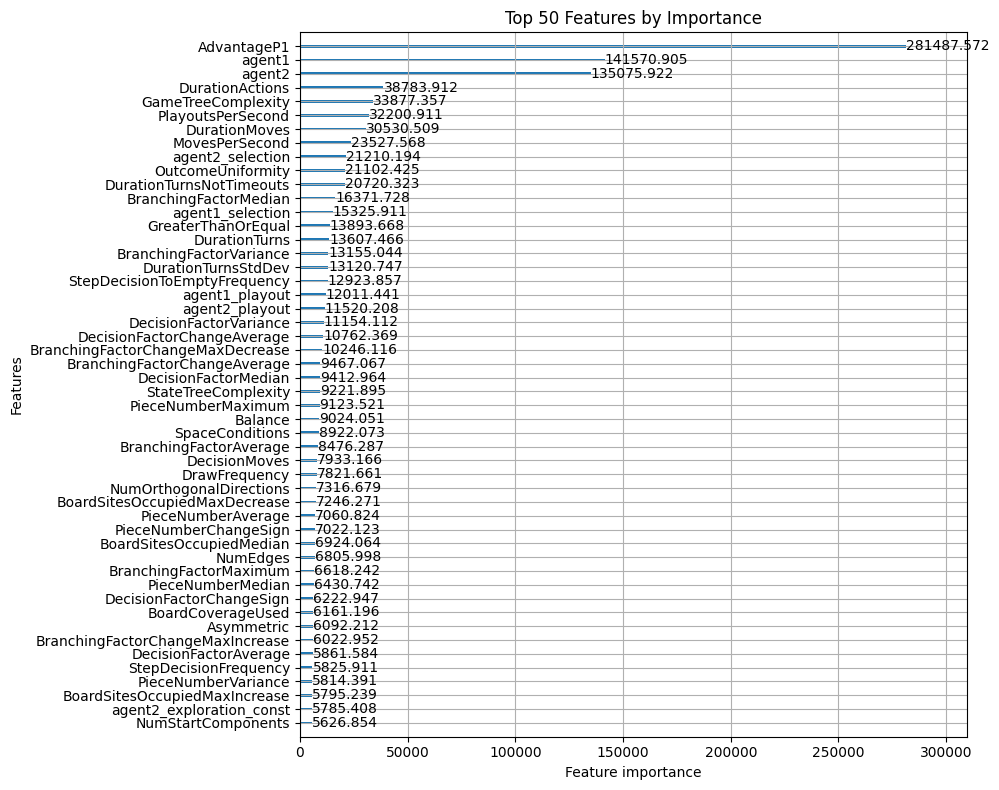

Fold 5 - RMSE: 0.42691198689155113
List of oof scores: [0.4340318675317364, 0.4164862497948062, 0.42481736086199184, 0.41666961646885337, 0.42691198689155113]
Average oof score: 0.4237834163097878


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4292
Score: 0.4491
Score: 0.4402
Score: 0.4352
Score: 0.4057
Average CV1 Score: 0.4319

CV2 OOF Scores:
Score: 0.4134
Score: 0.4037
Score: 0.4337
Score: 0.4423
Score: 0.4368
Average CV2 Score: 0.4260

CV3 OOF Scores:
Score: 0.4340
Score: 0.4165
Score: 0.4248
Score: 0.4167
Score: 0.4269
Average CV3 Score: 0.4238


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

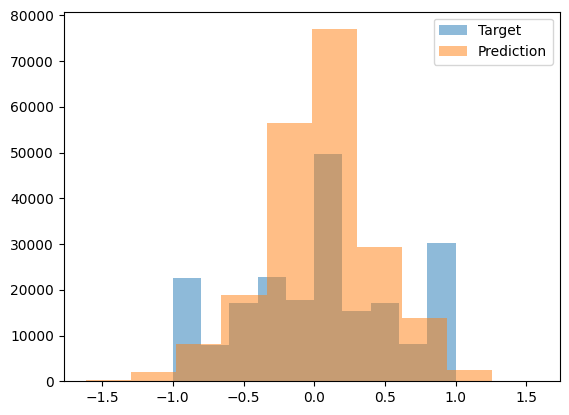

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.131468       │
│ 233235 ┆ -0.181452      │
│ 233236 ┆ -0.02178       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***